In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as widgets
from tqdm.notebook import tqdm
import plot_utils as u
from scipy.interpolate import griddata
from matplotlib import cm

In [2]:
result_file = "DBS_amplitude_effect_computed_values.pickle"
with open(result_file, "rb") as f:
    results = pickle.load(f)

In [3]:
results_per_seed = dict()

for res in tqdm(results):
    seed = res["random_seed"]
    if seed in results_per_seed:
        results_per_seed[seed].append(res)
    else:
        results_per_seed[seed] = [res]

  0%|          | 0/1848 [00:00<?, ?it/s]

In [4]:
plot_data_per_seed = dict()

for seed in results_per_seed:
    x = []
    y = []
    z = []
    z_lfp = []
    
    for res in results_per_seed[seed]:
        x.append(res["stim_amplitude"])
        y.append(res["dc_offset"])
        z.append(res["beta"])
        z_lfp.append(res["beta_lfp"])
    x = np.array(x)
    y = np.array(y)
    xi = np.arange(x.min(), x.max(), 0.001)
    yi = np.arange(y.min(), y.max(), 0.001)
    xi, yi = np.meshgrid(xi, yi)
    zi = griddata((x, y), z, (xi, yi), "linear")
    zi_lfp = griddata((x, y), z_lfp, (xi, yi), "linear")
    plot_data_per_seed[seed] = {
        "x": x,
        "y": y,
        "xi": xi,
        "yi": yi,
        "zi": zi,
        "zi_lfp": zi_lfp,
    }

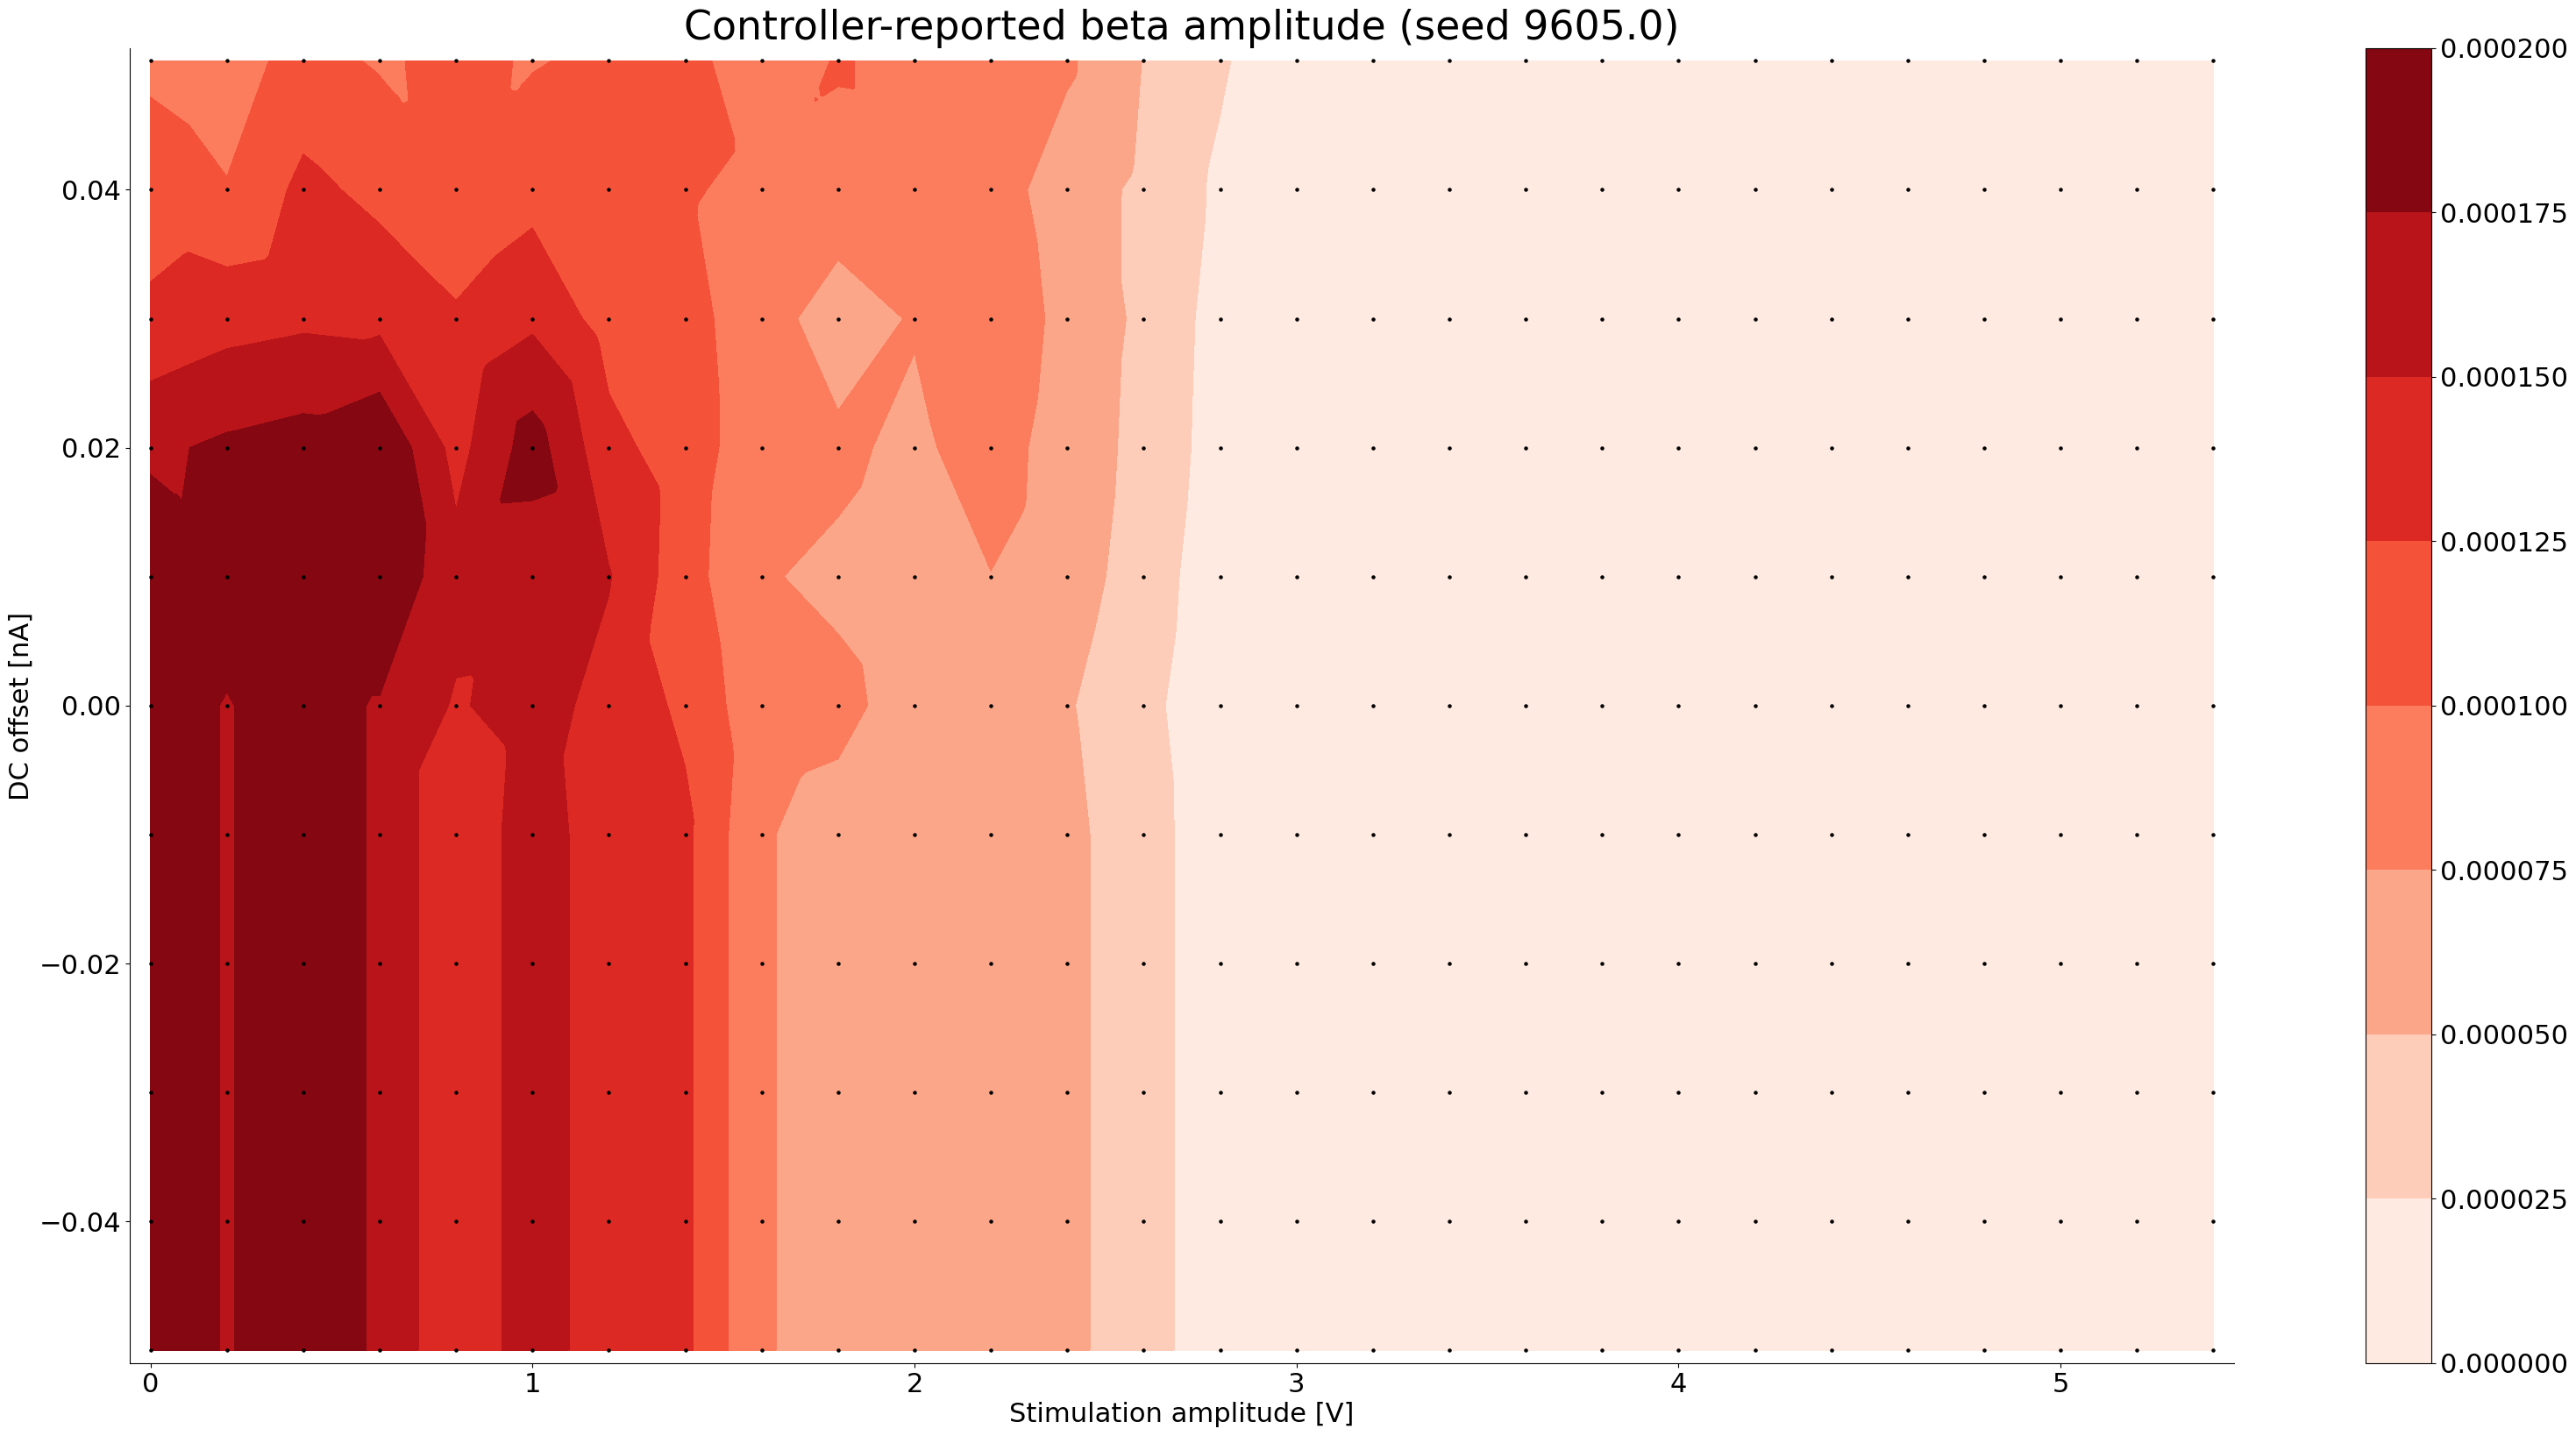

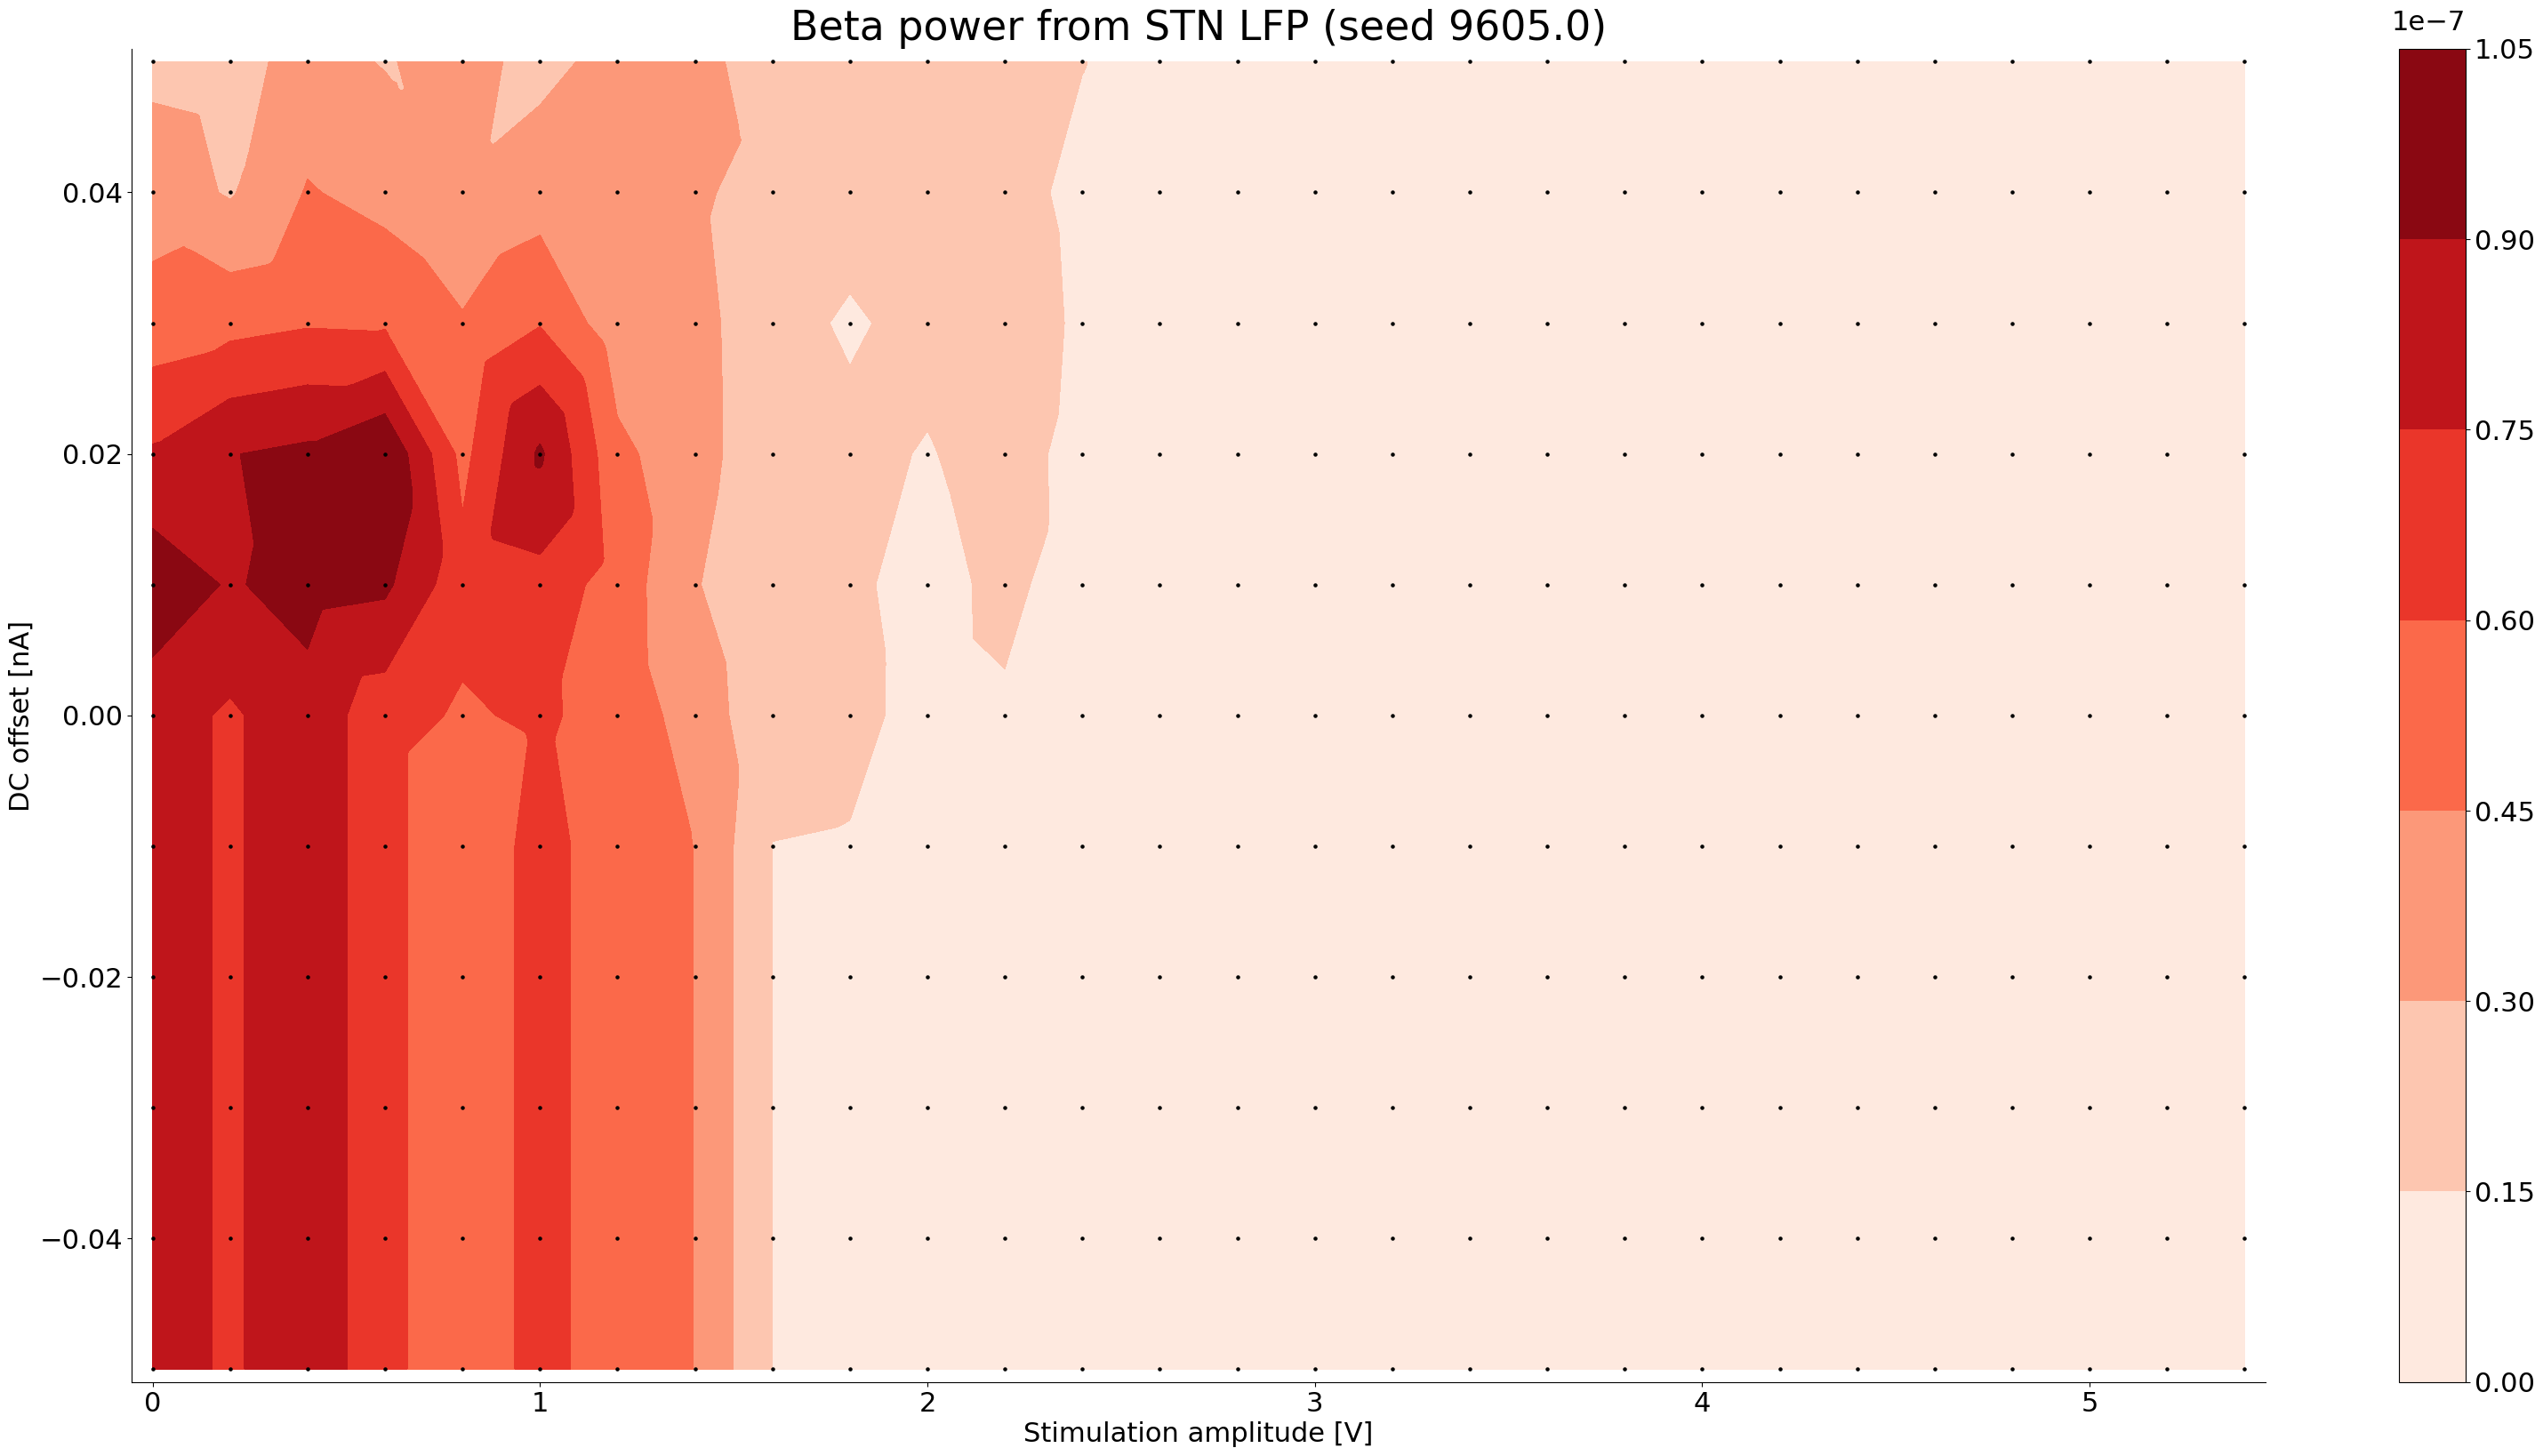

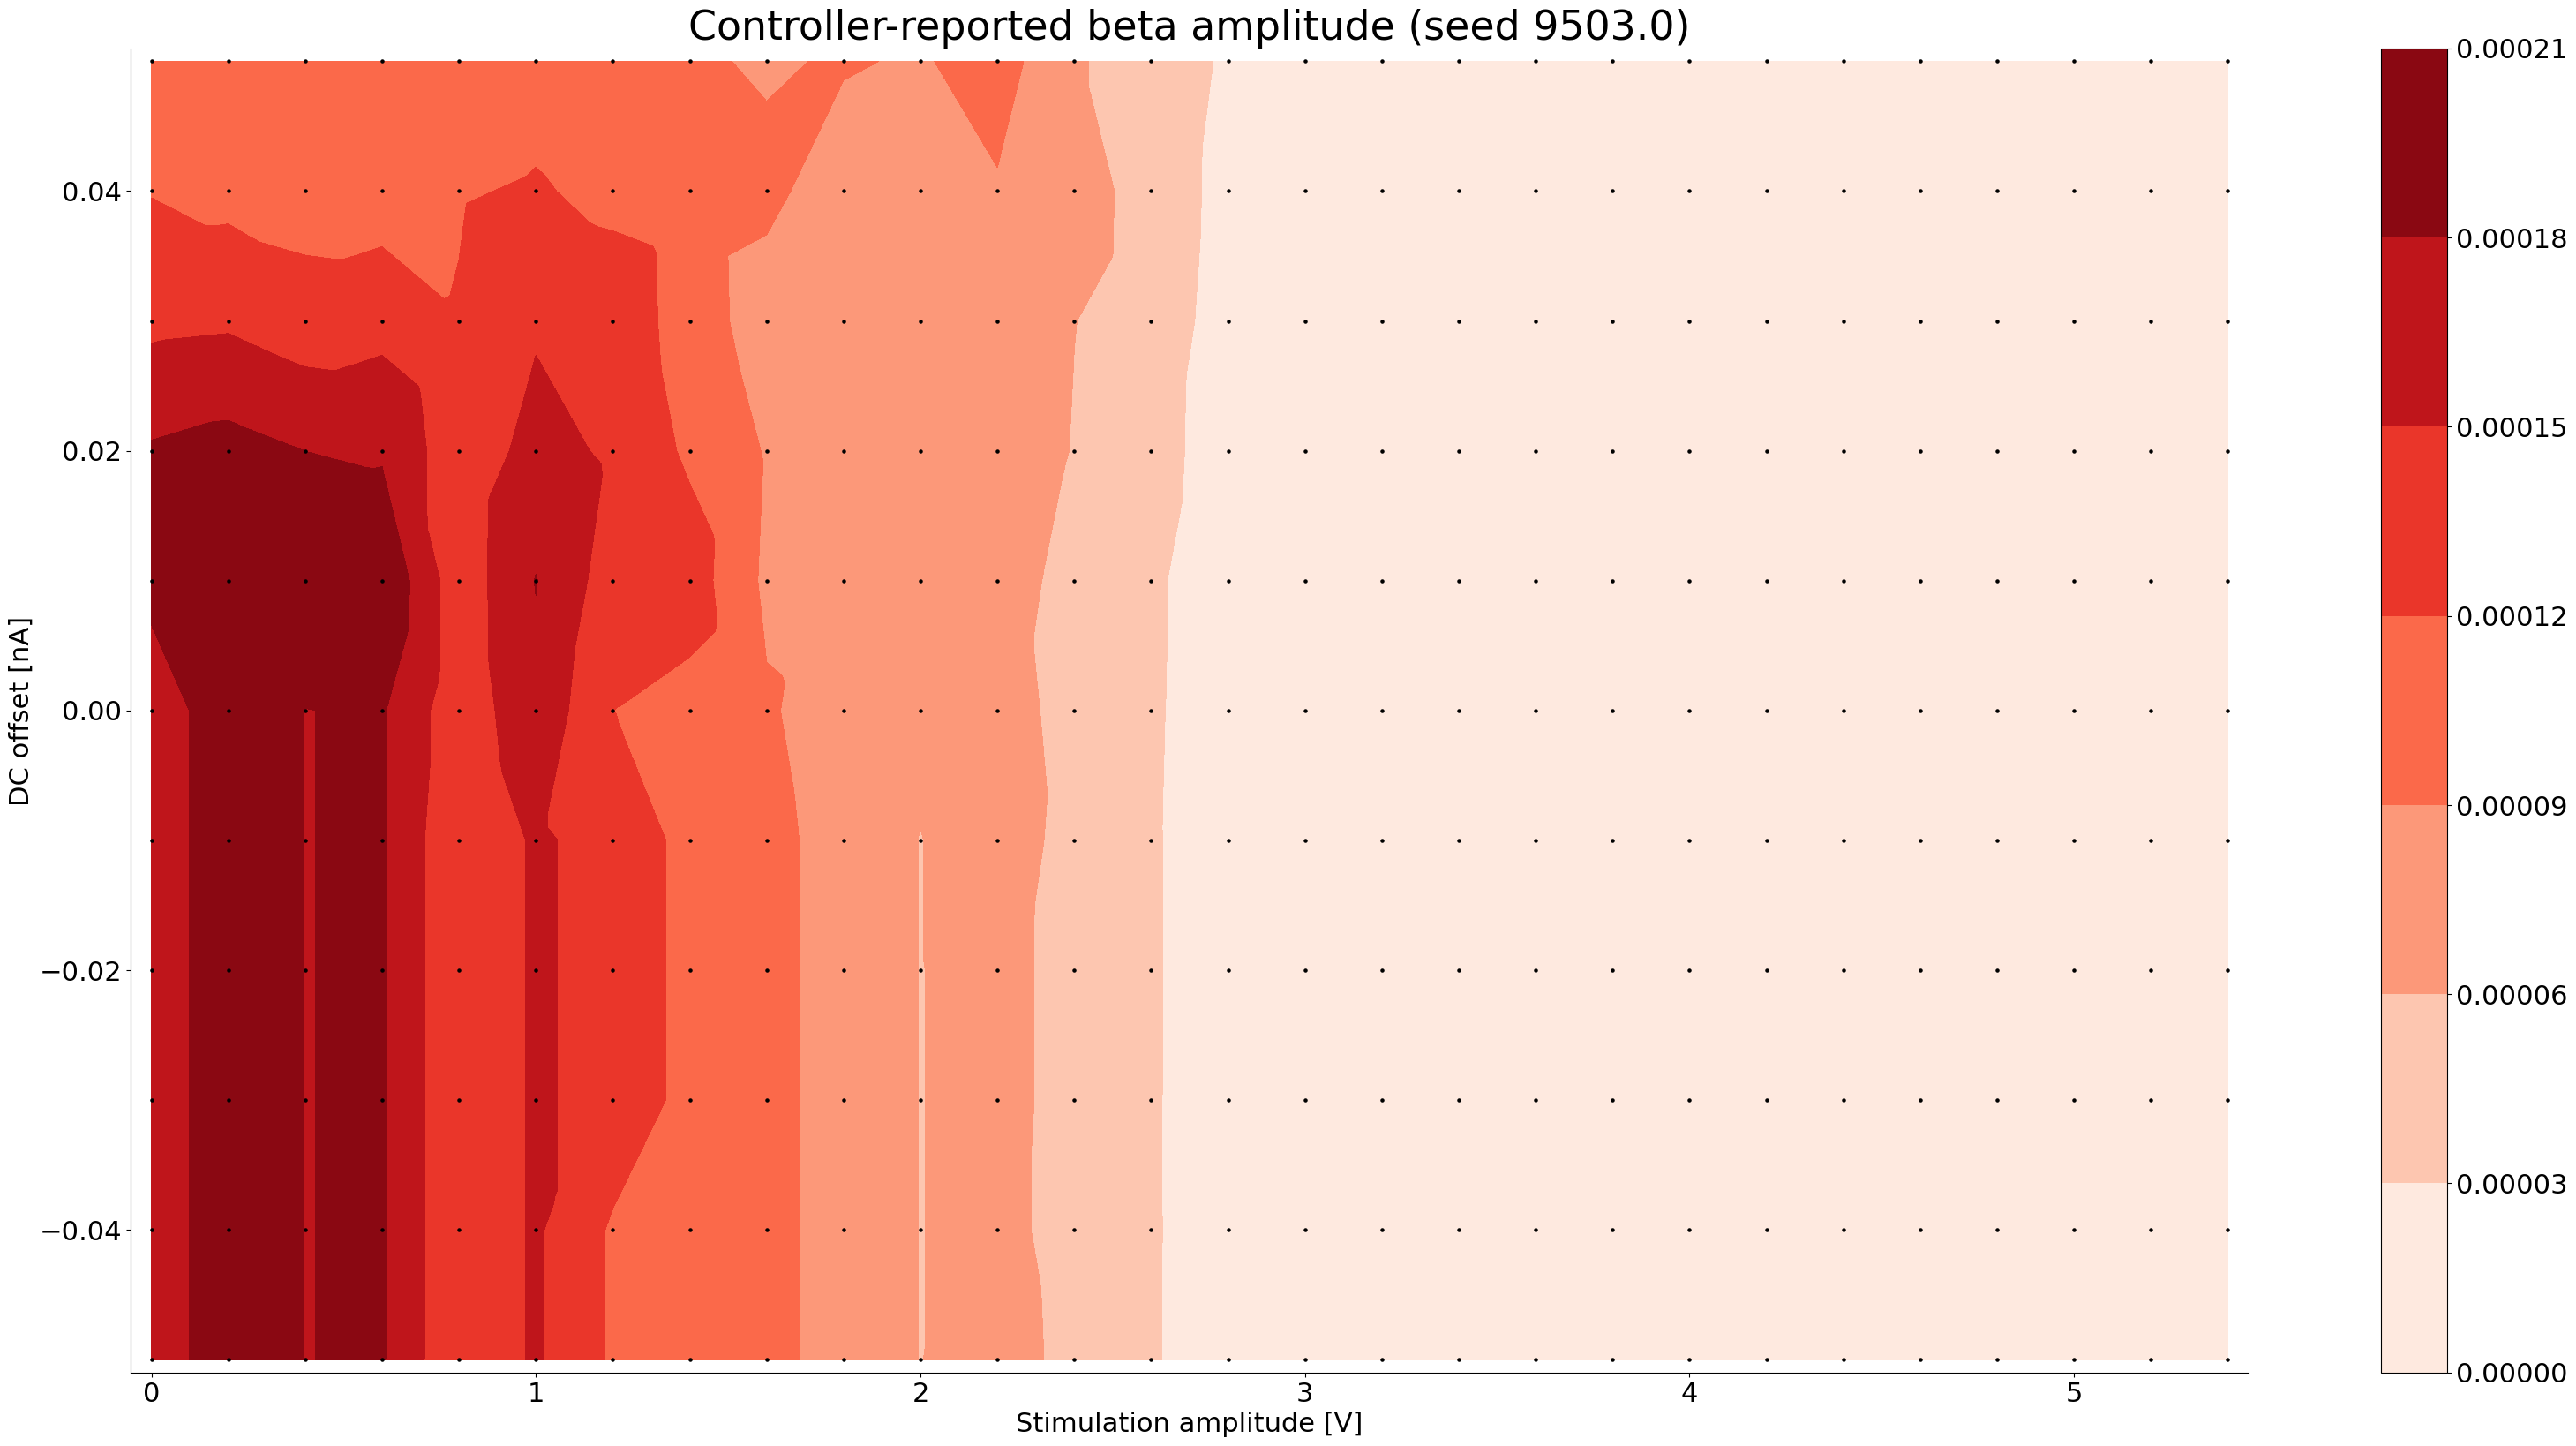

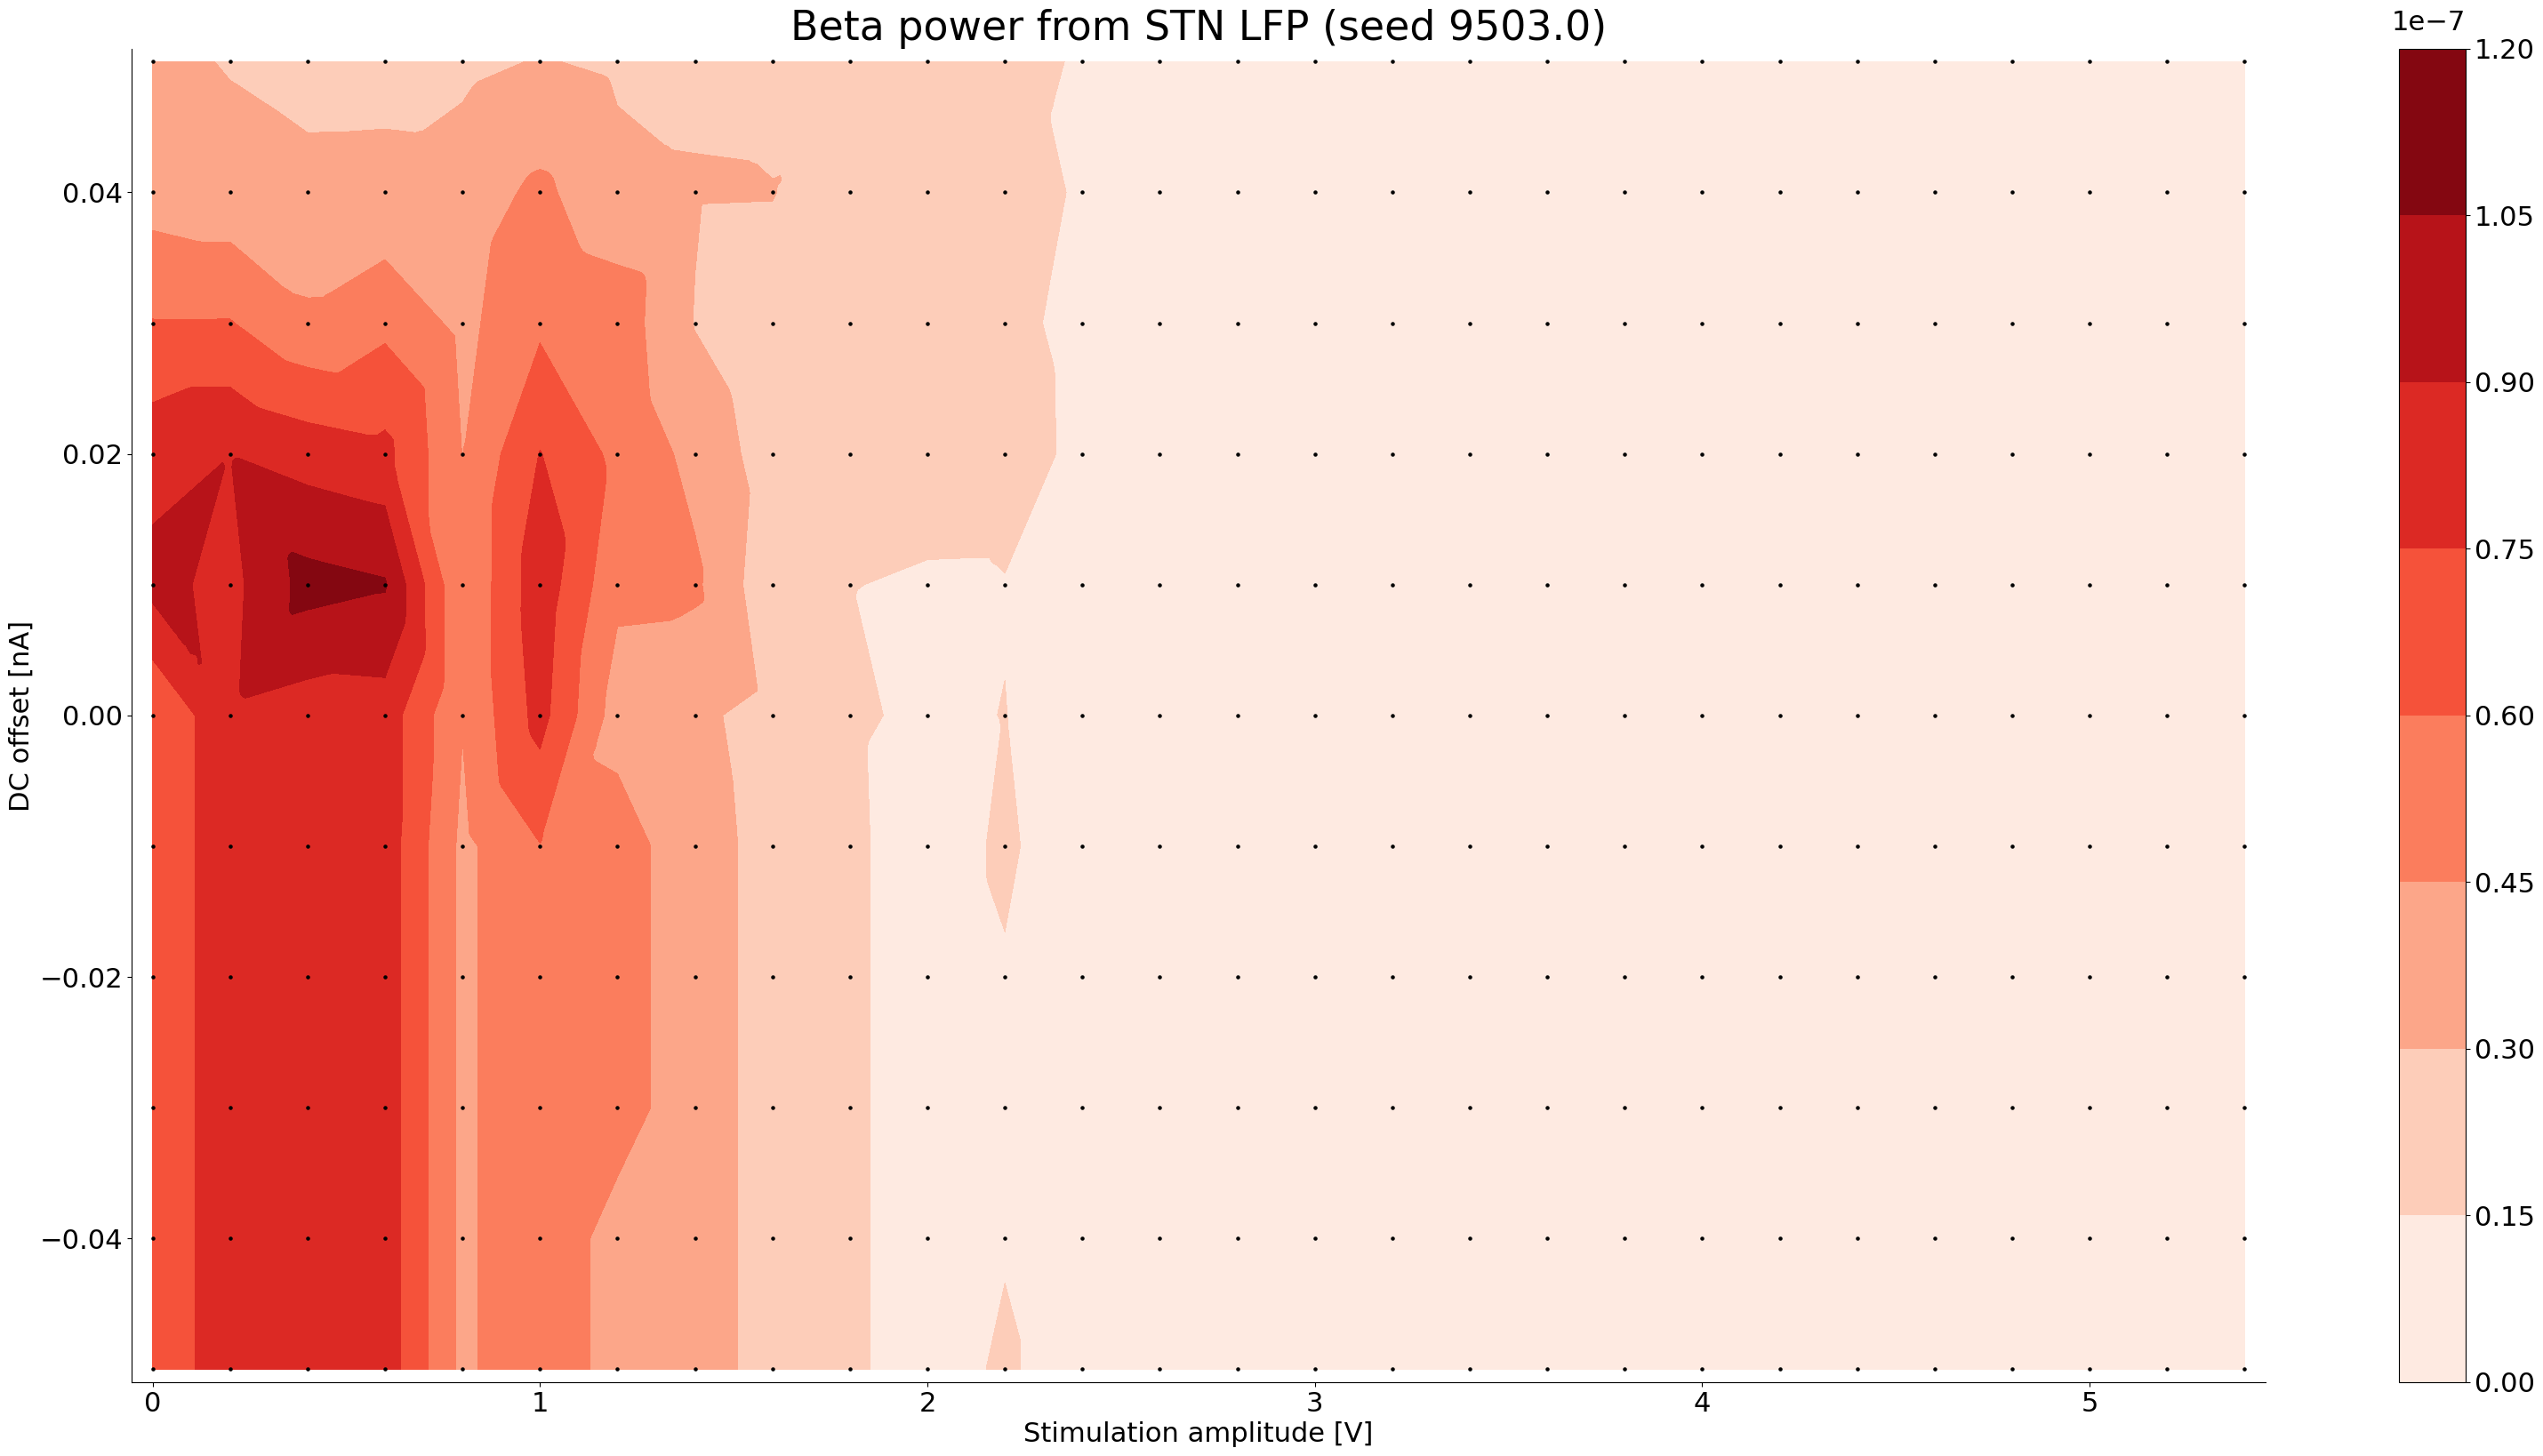

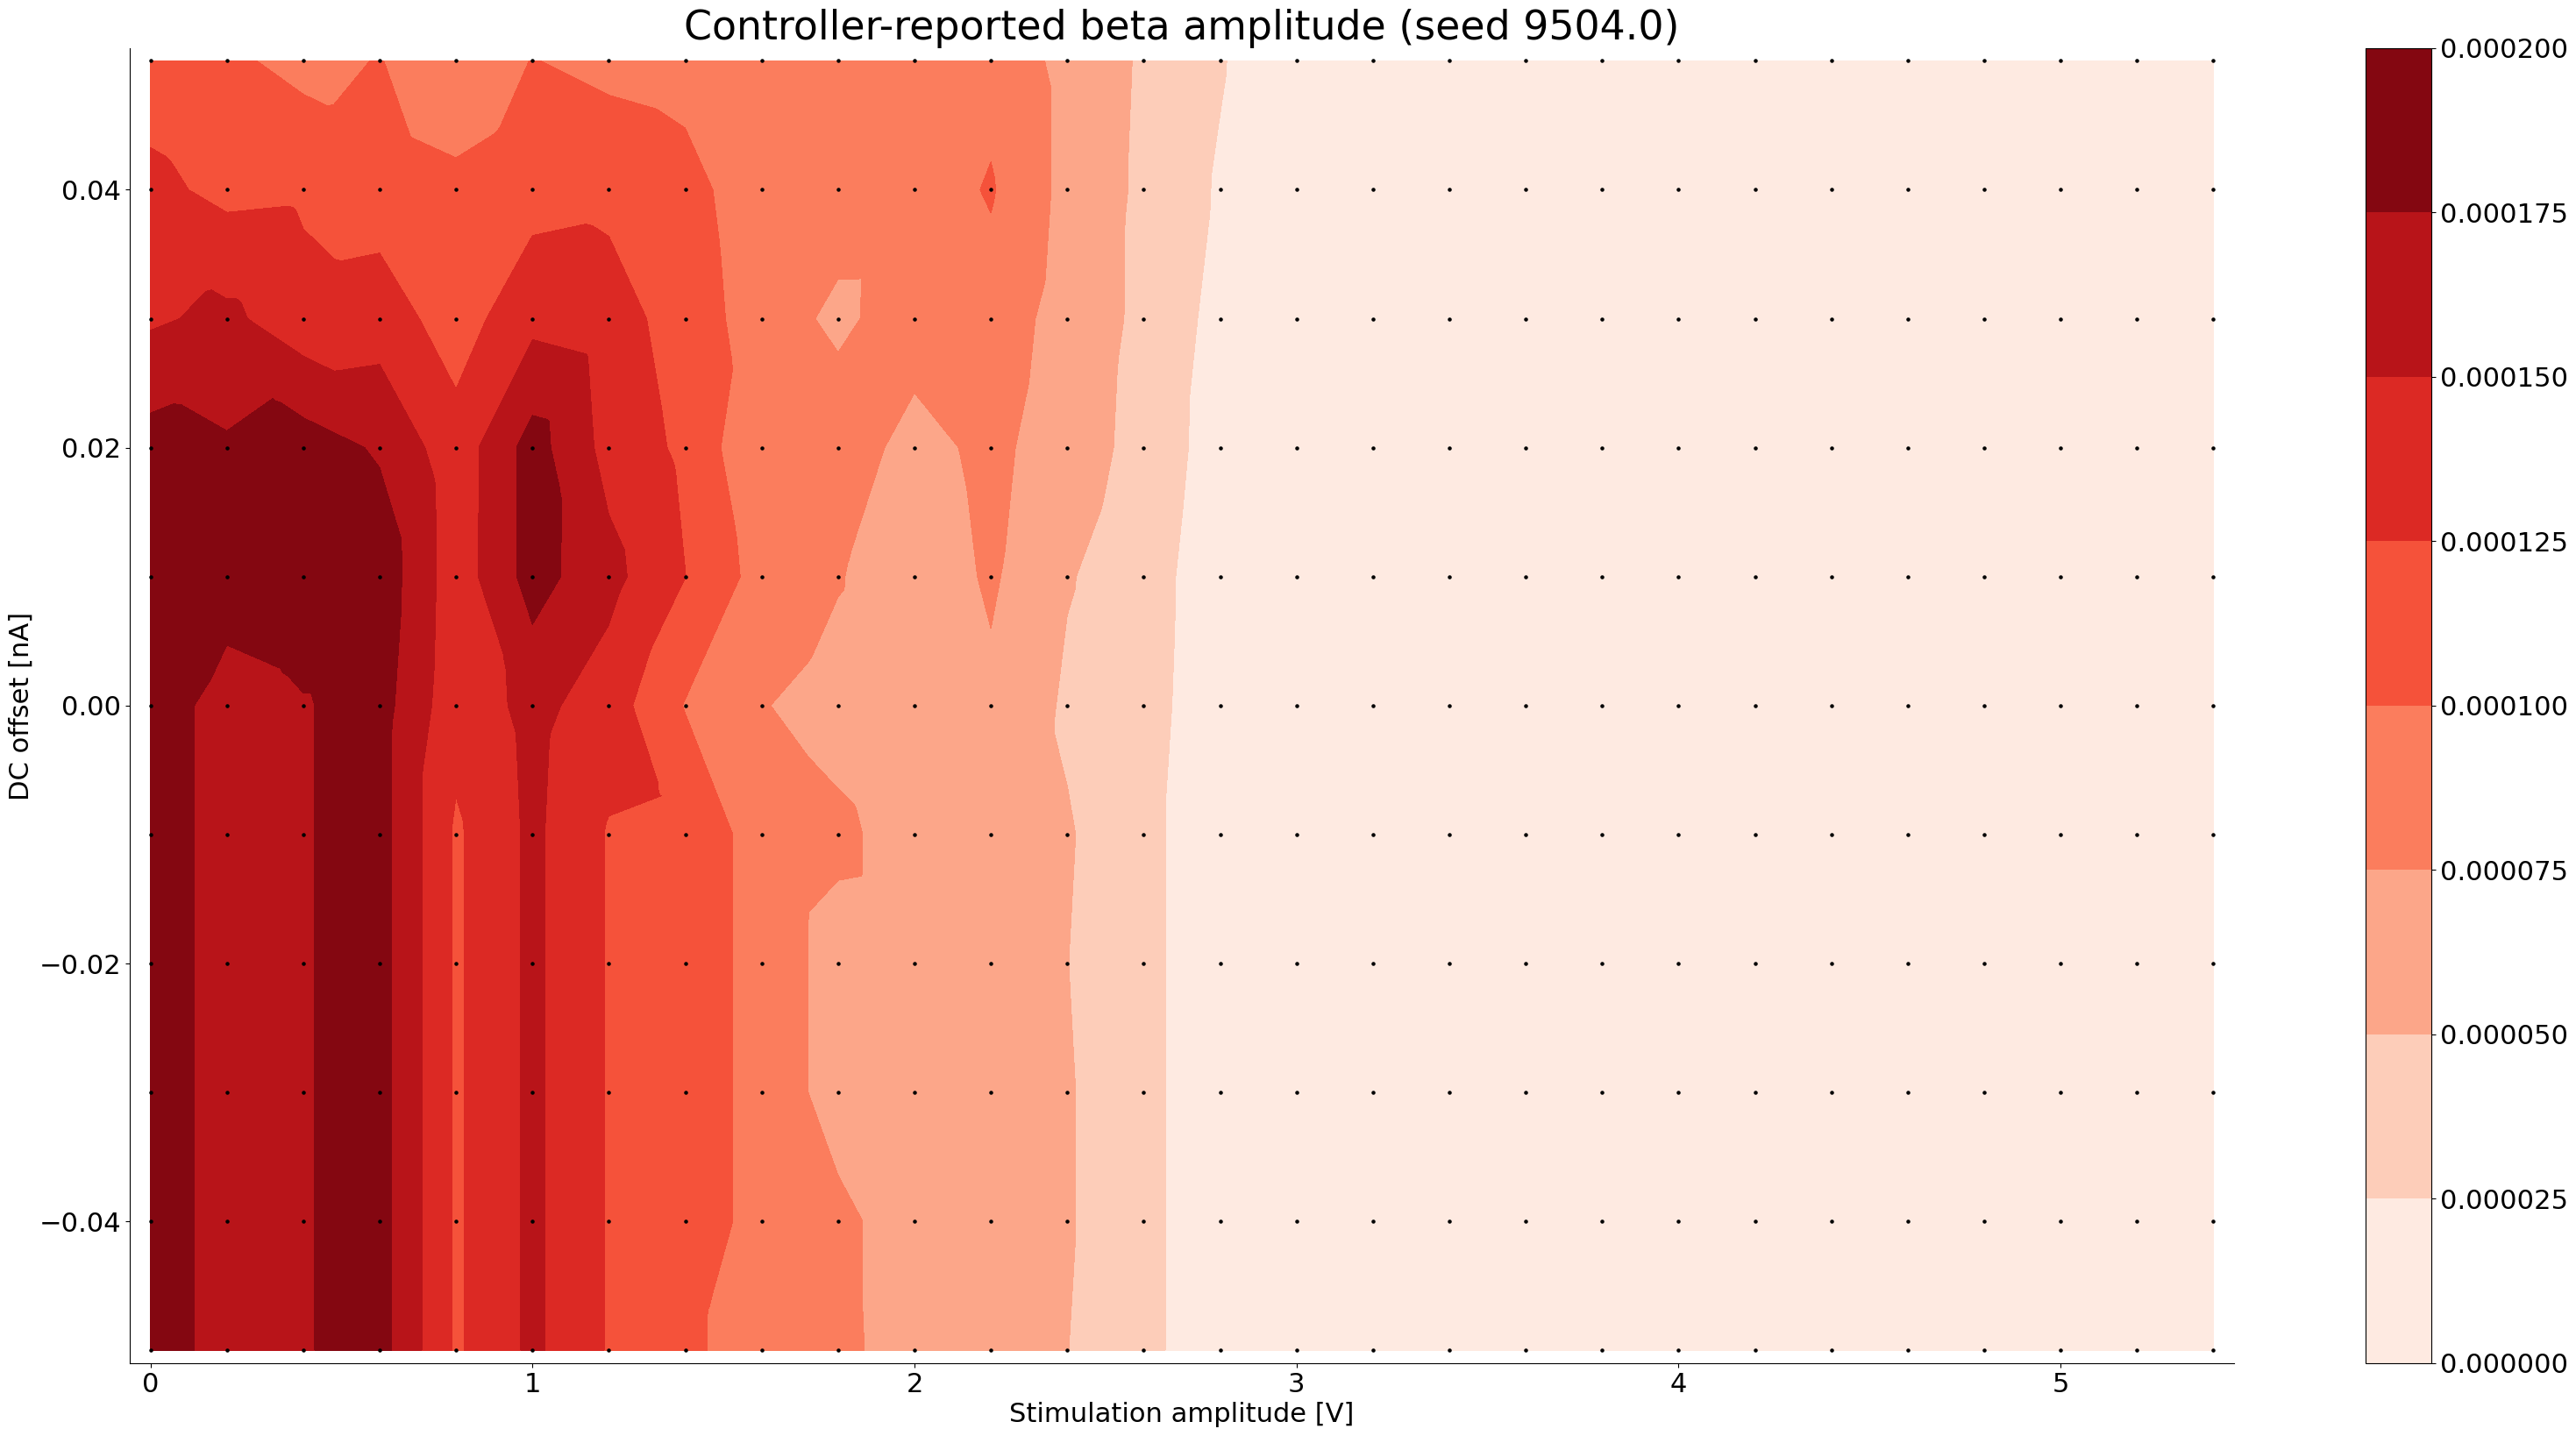

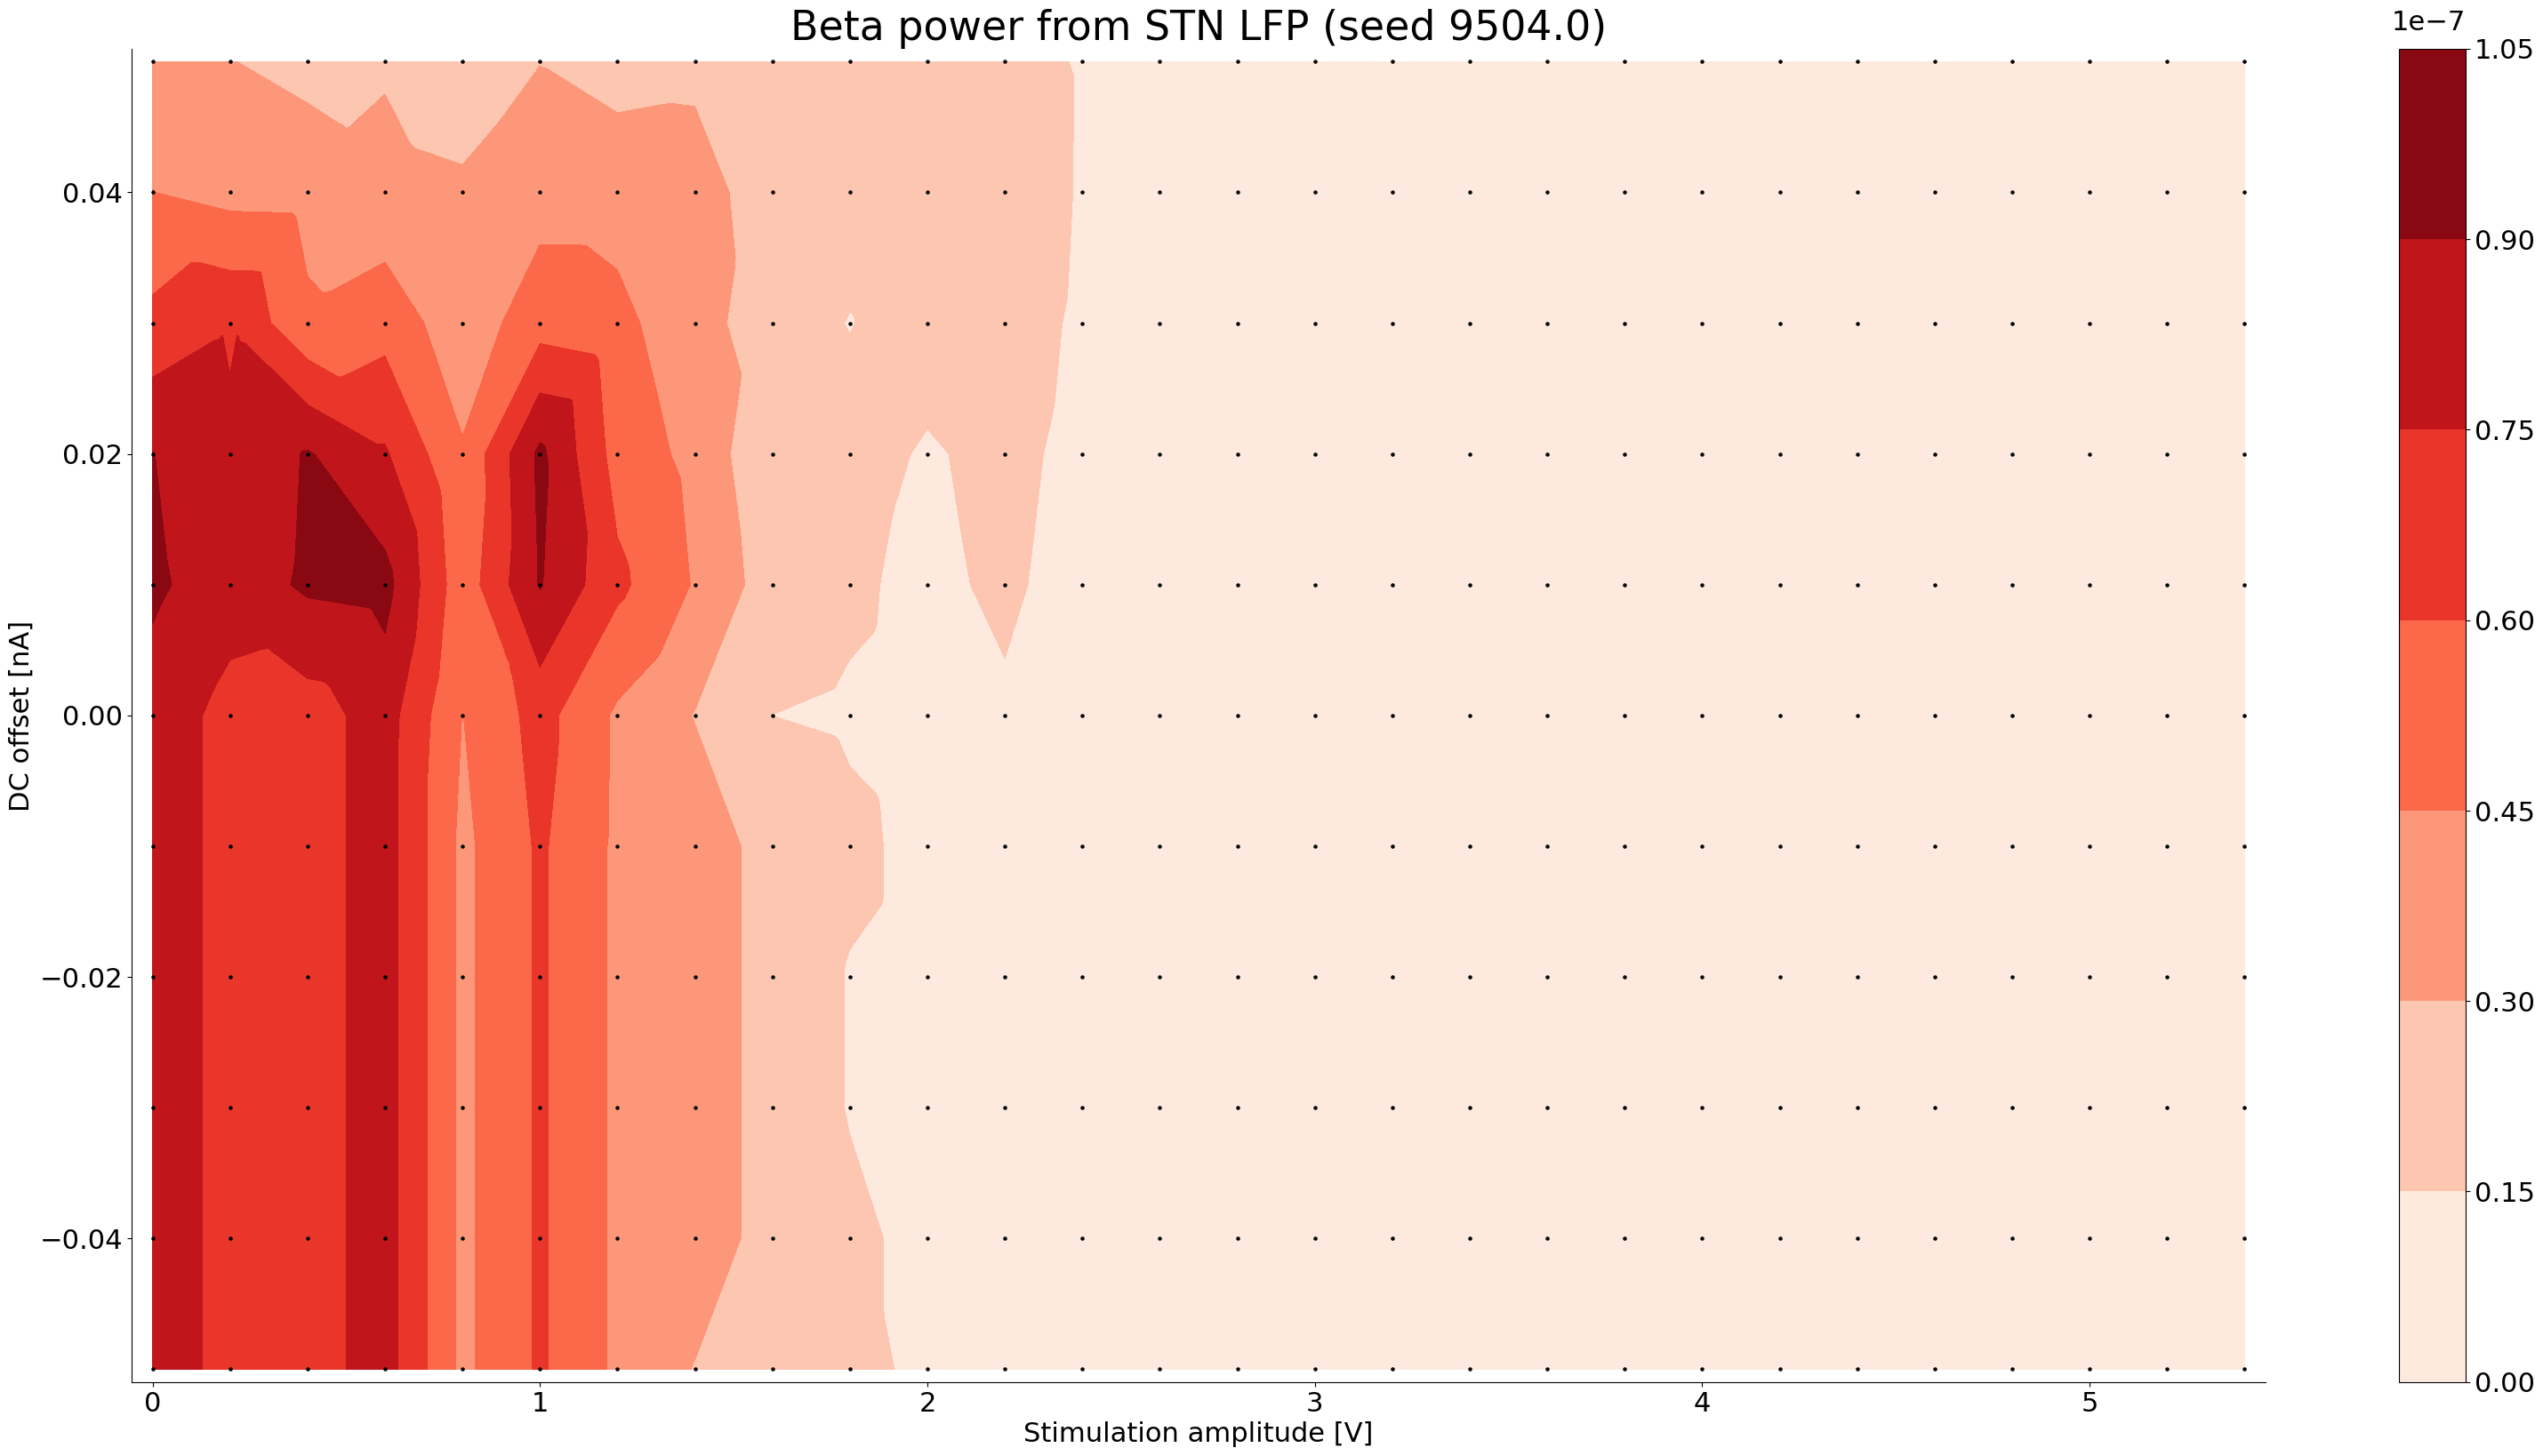

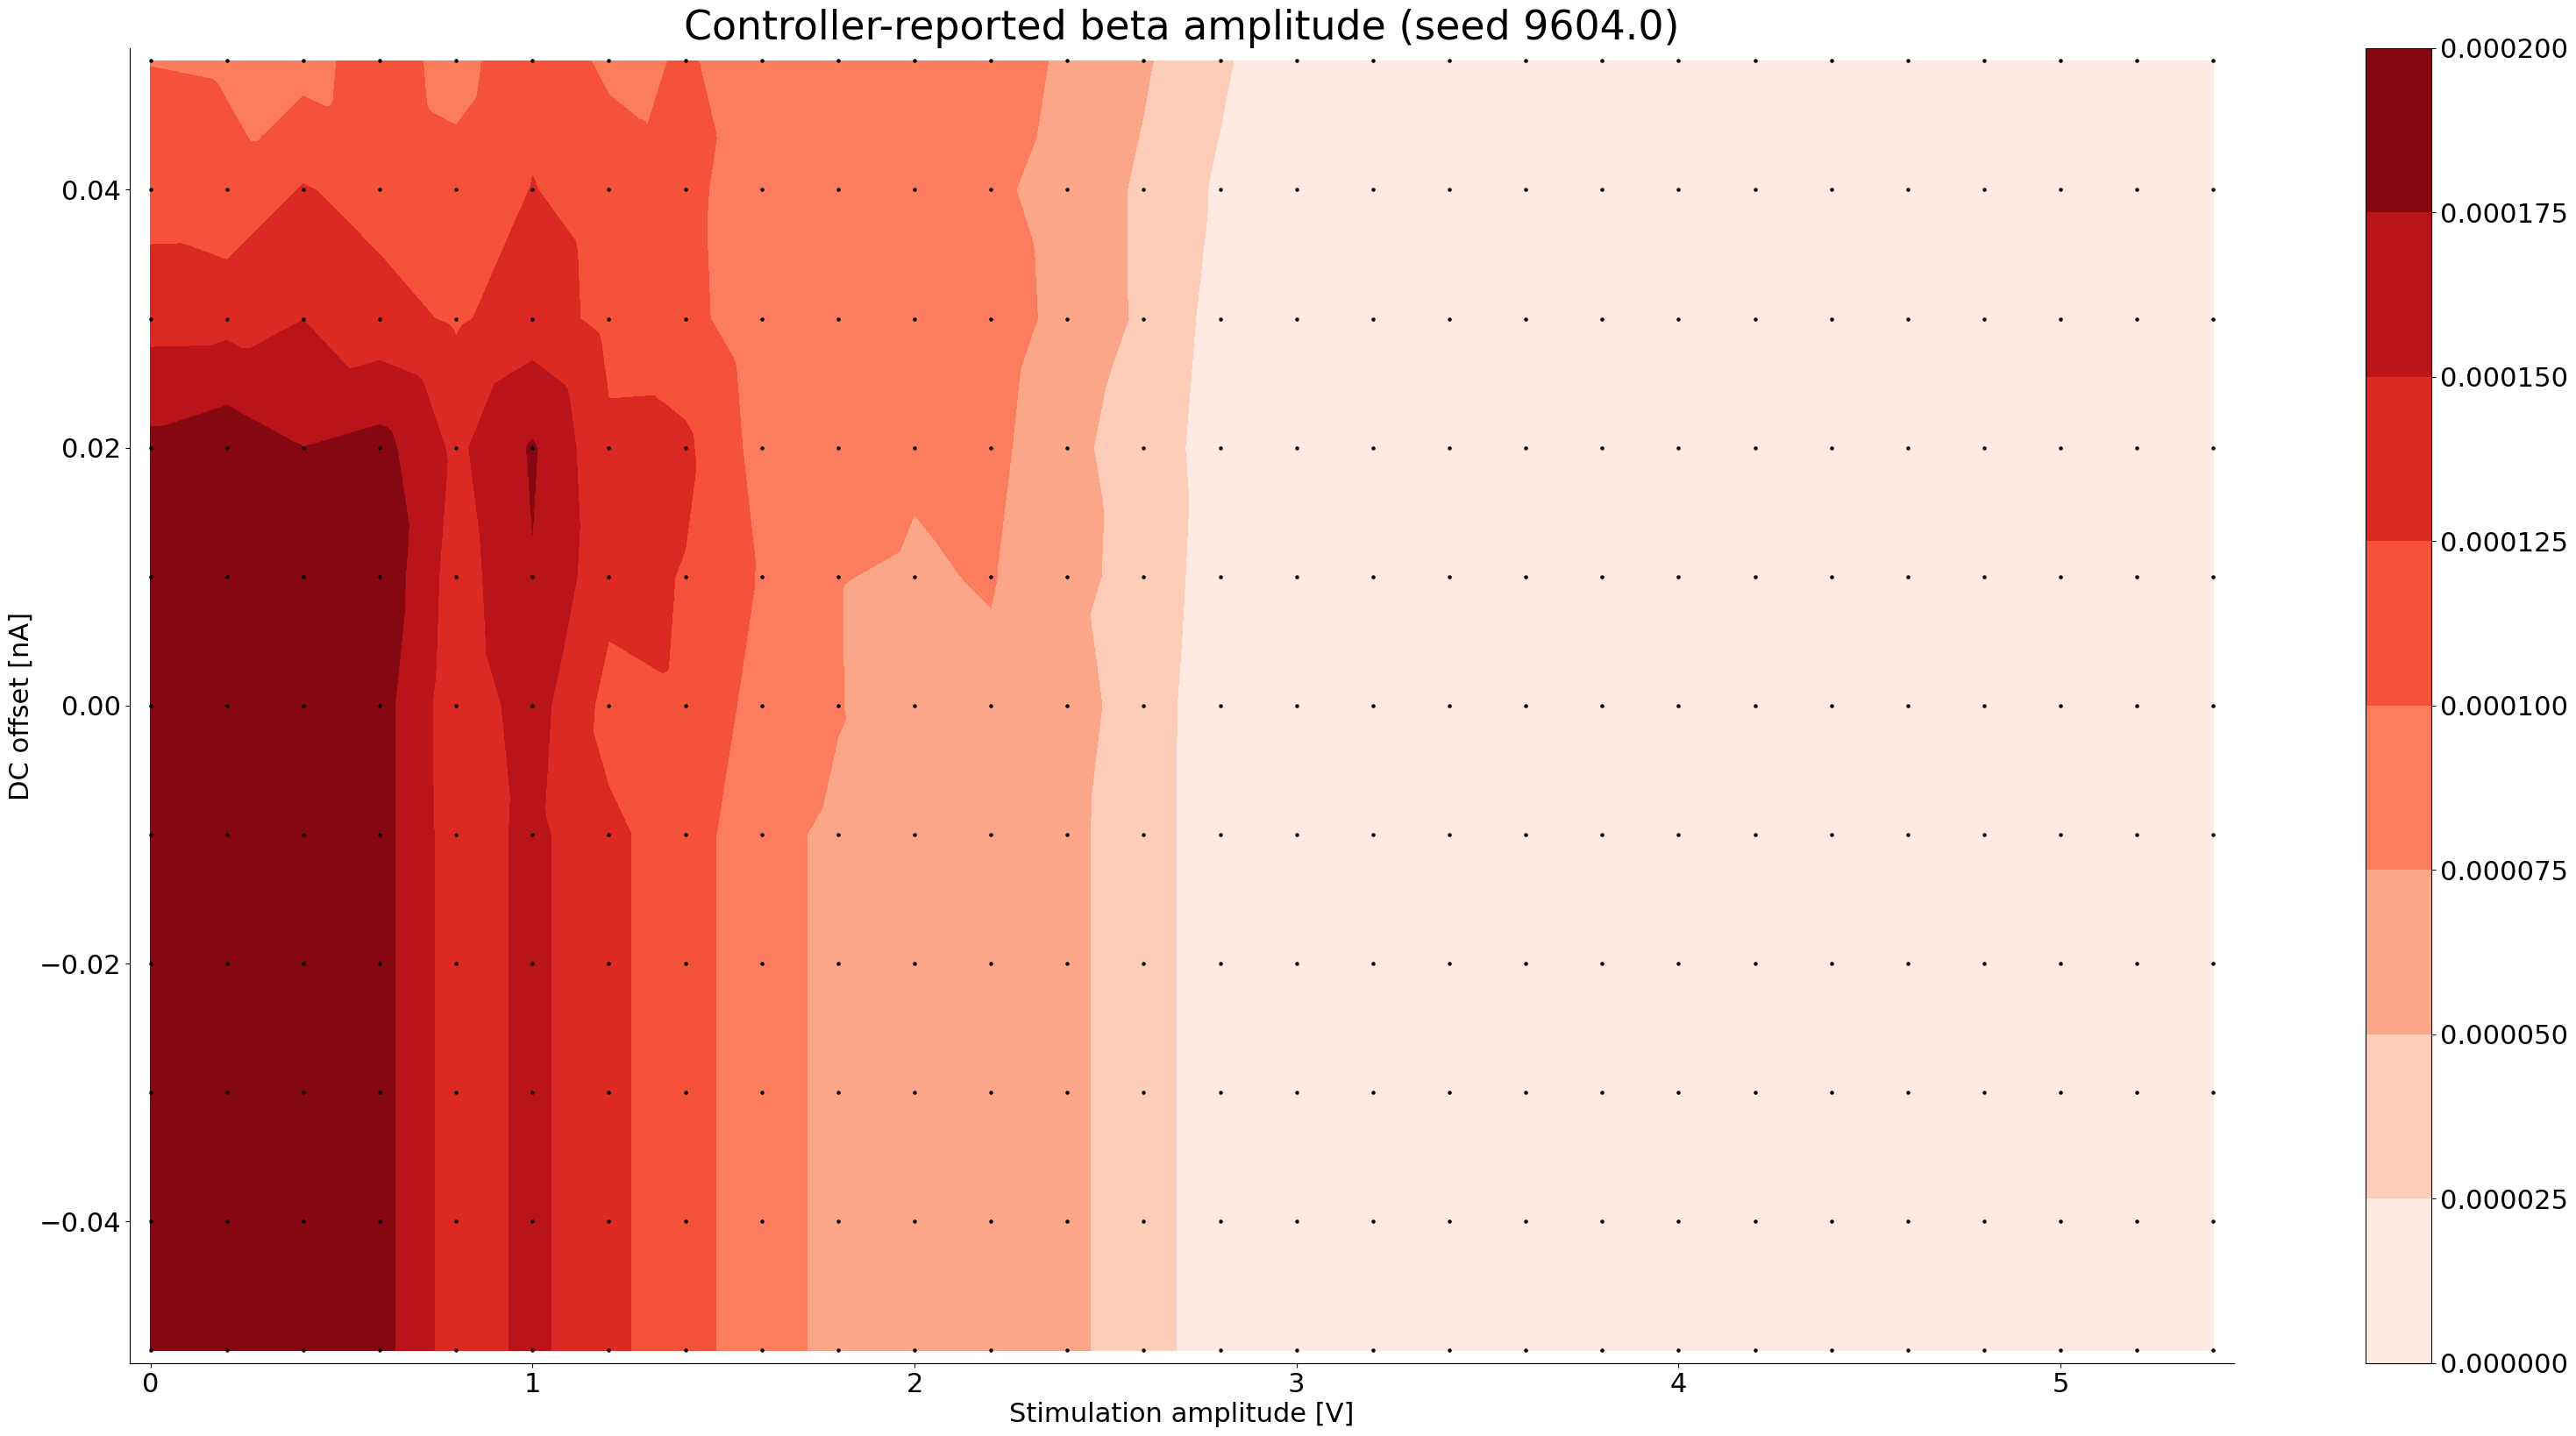

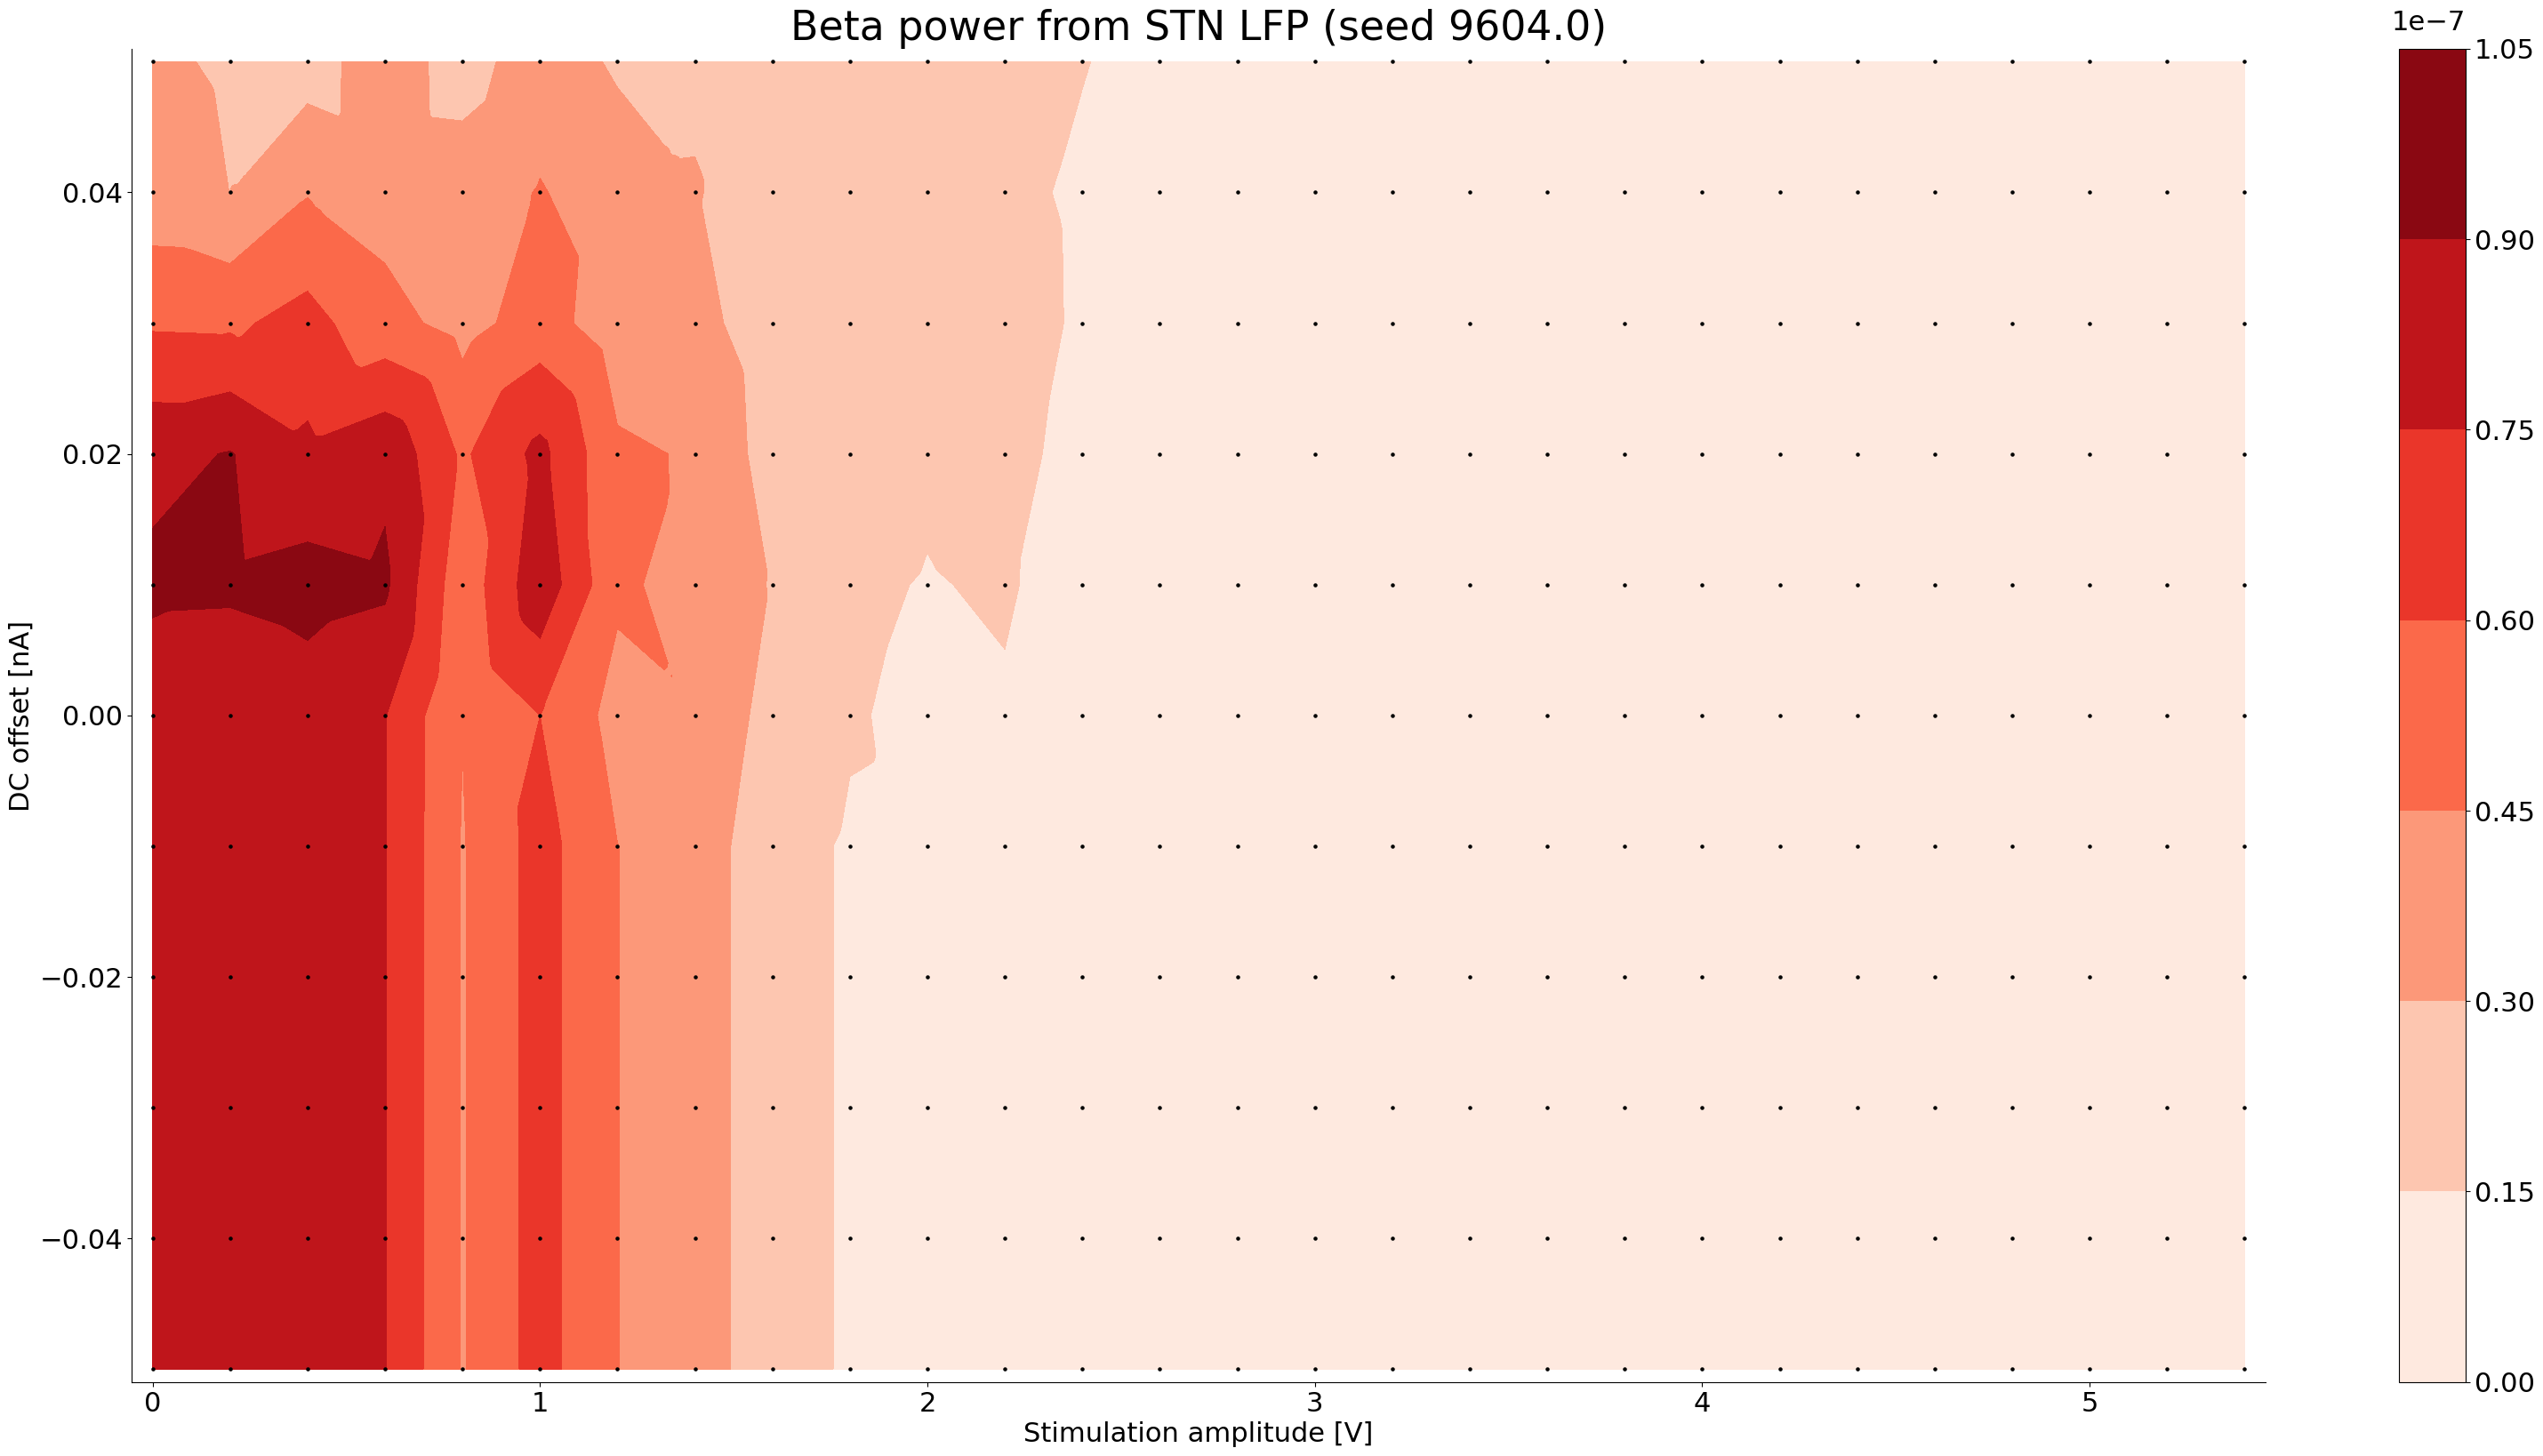

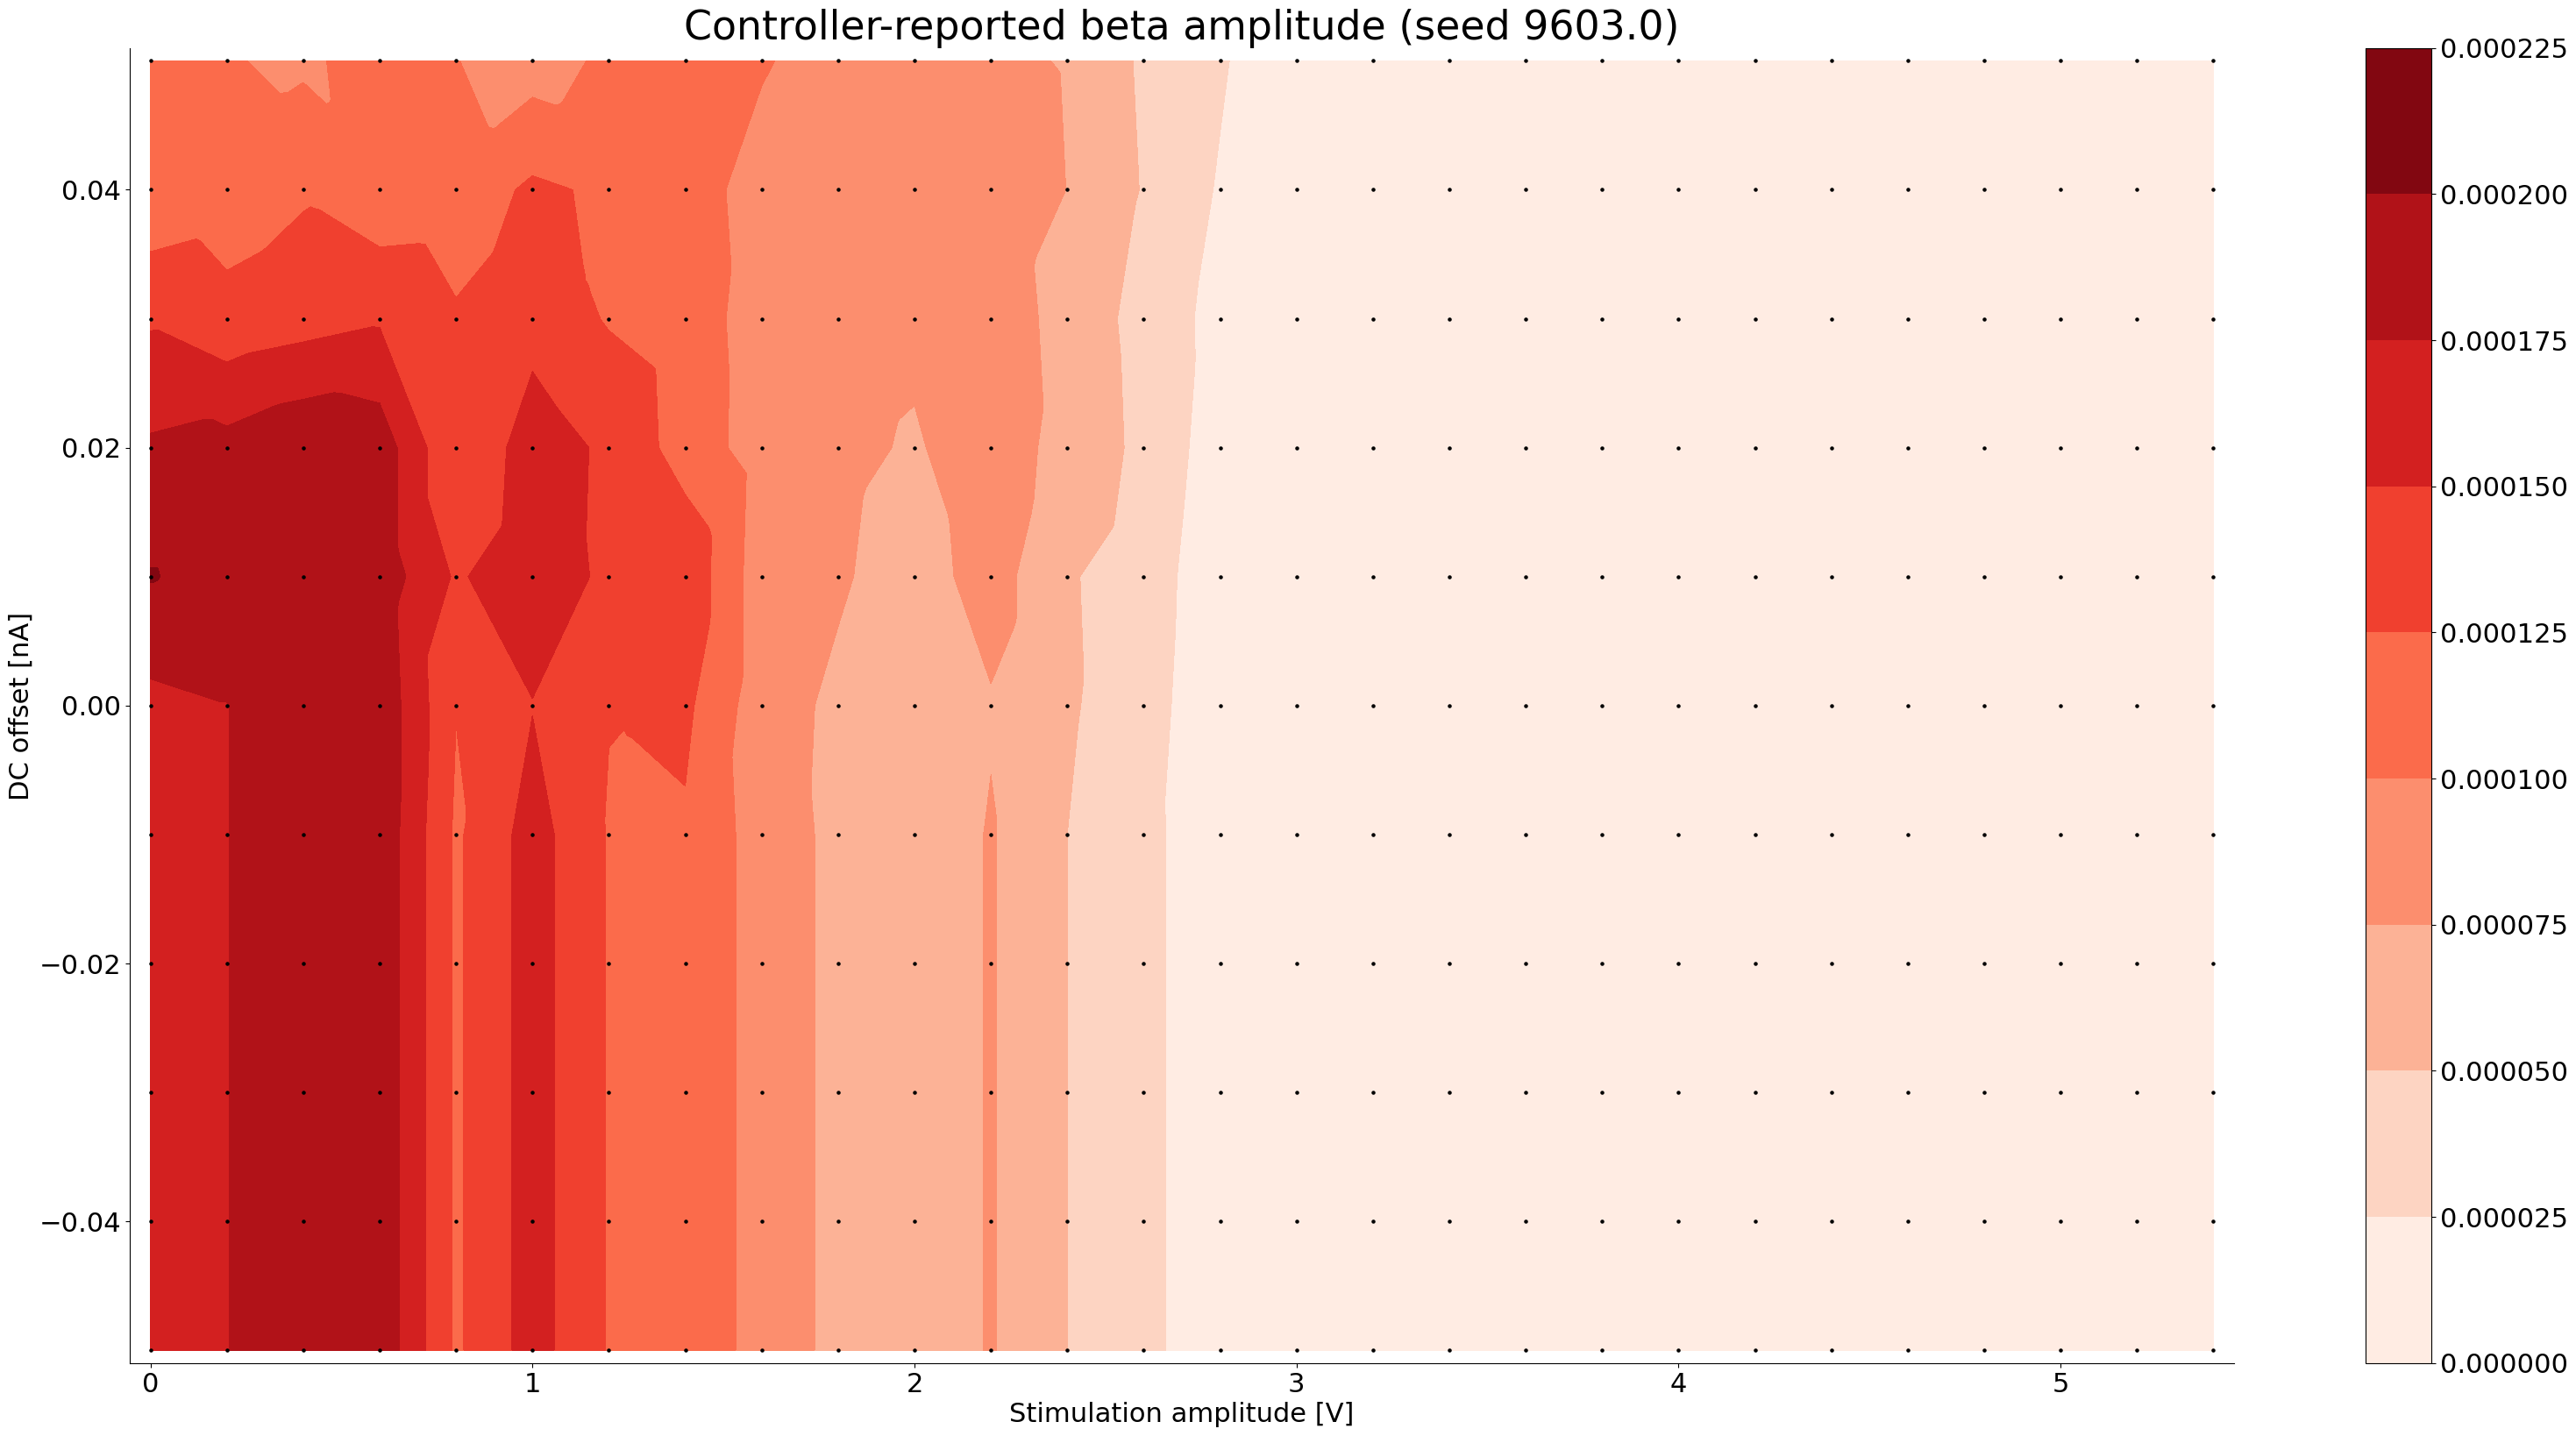

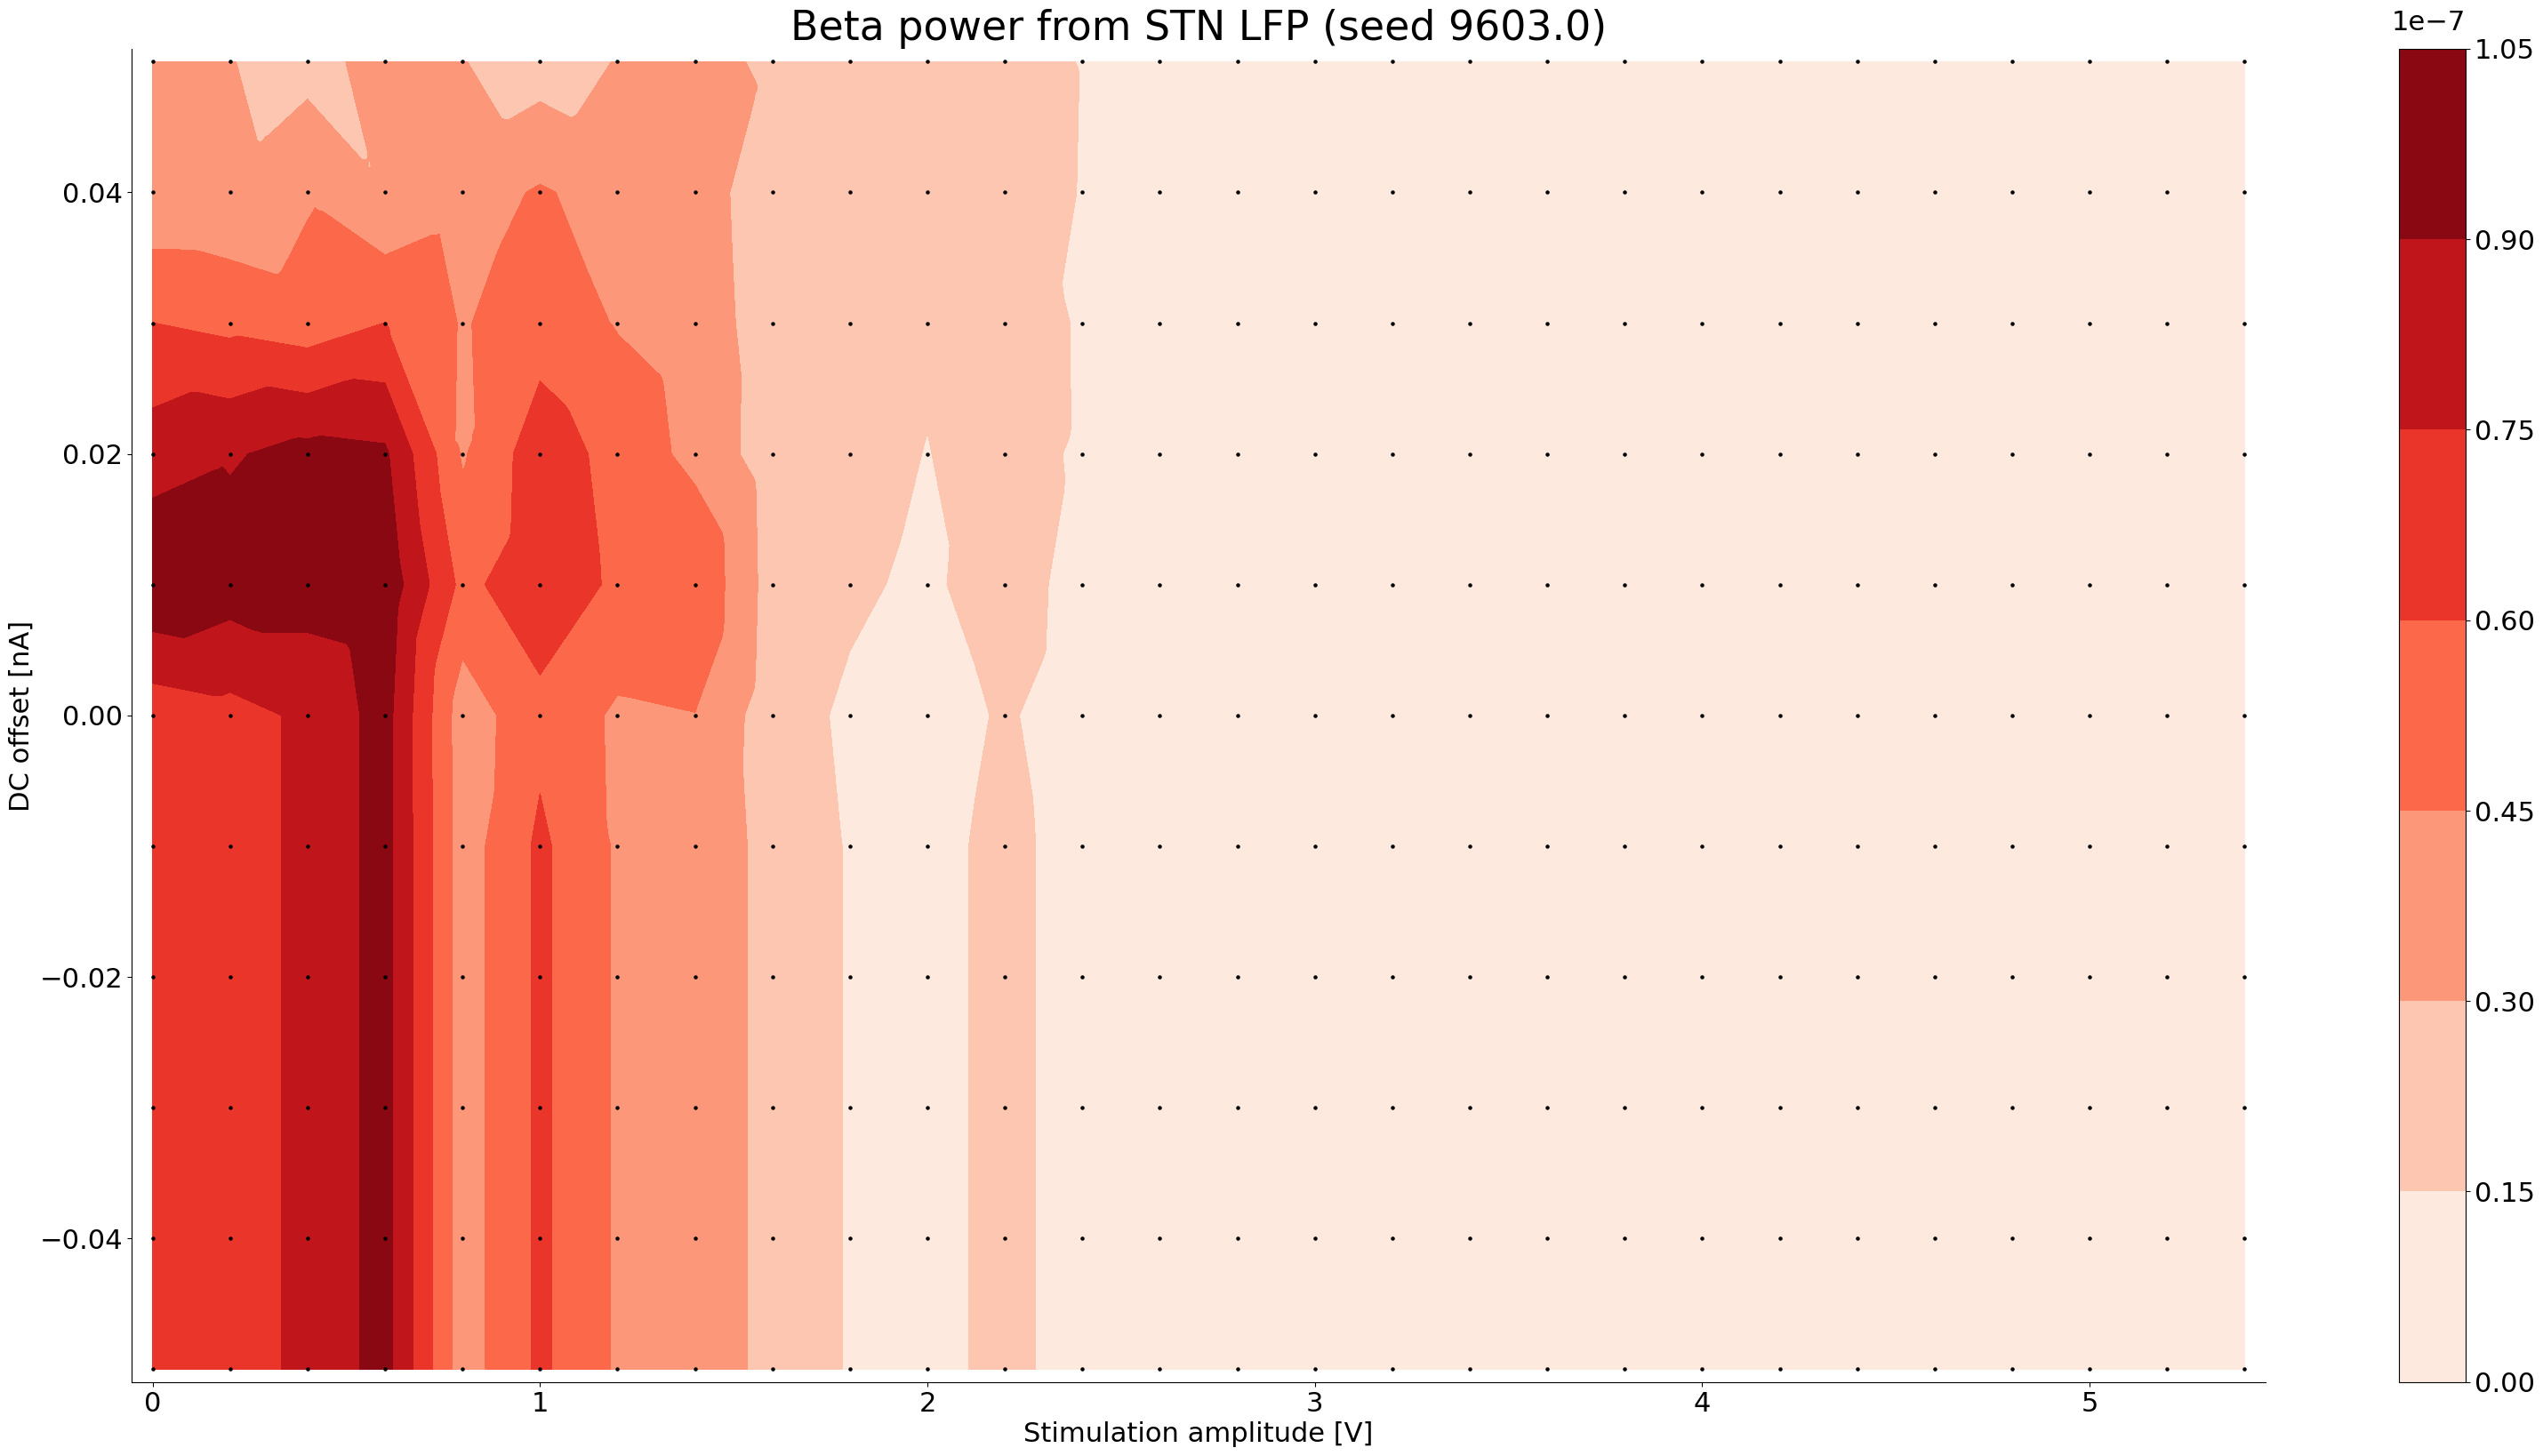

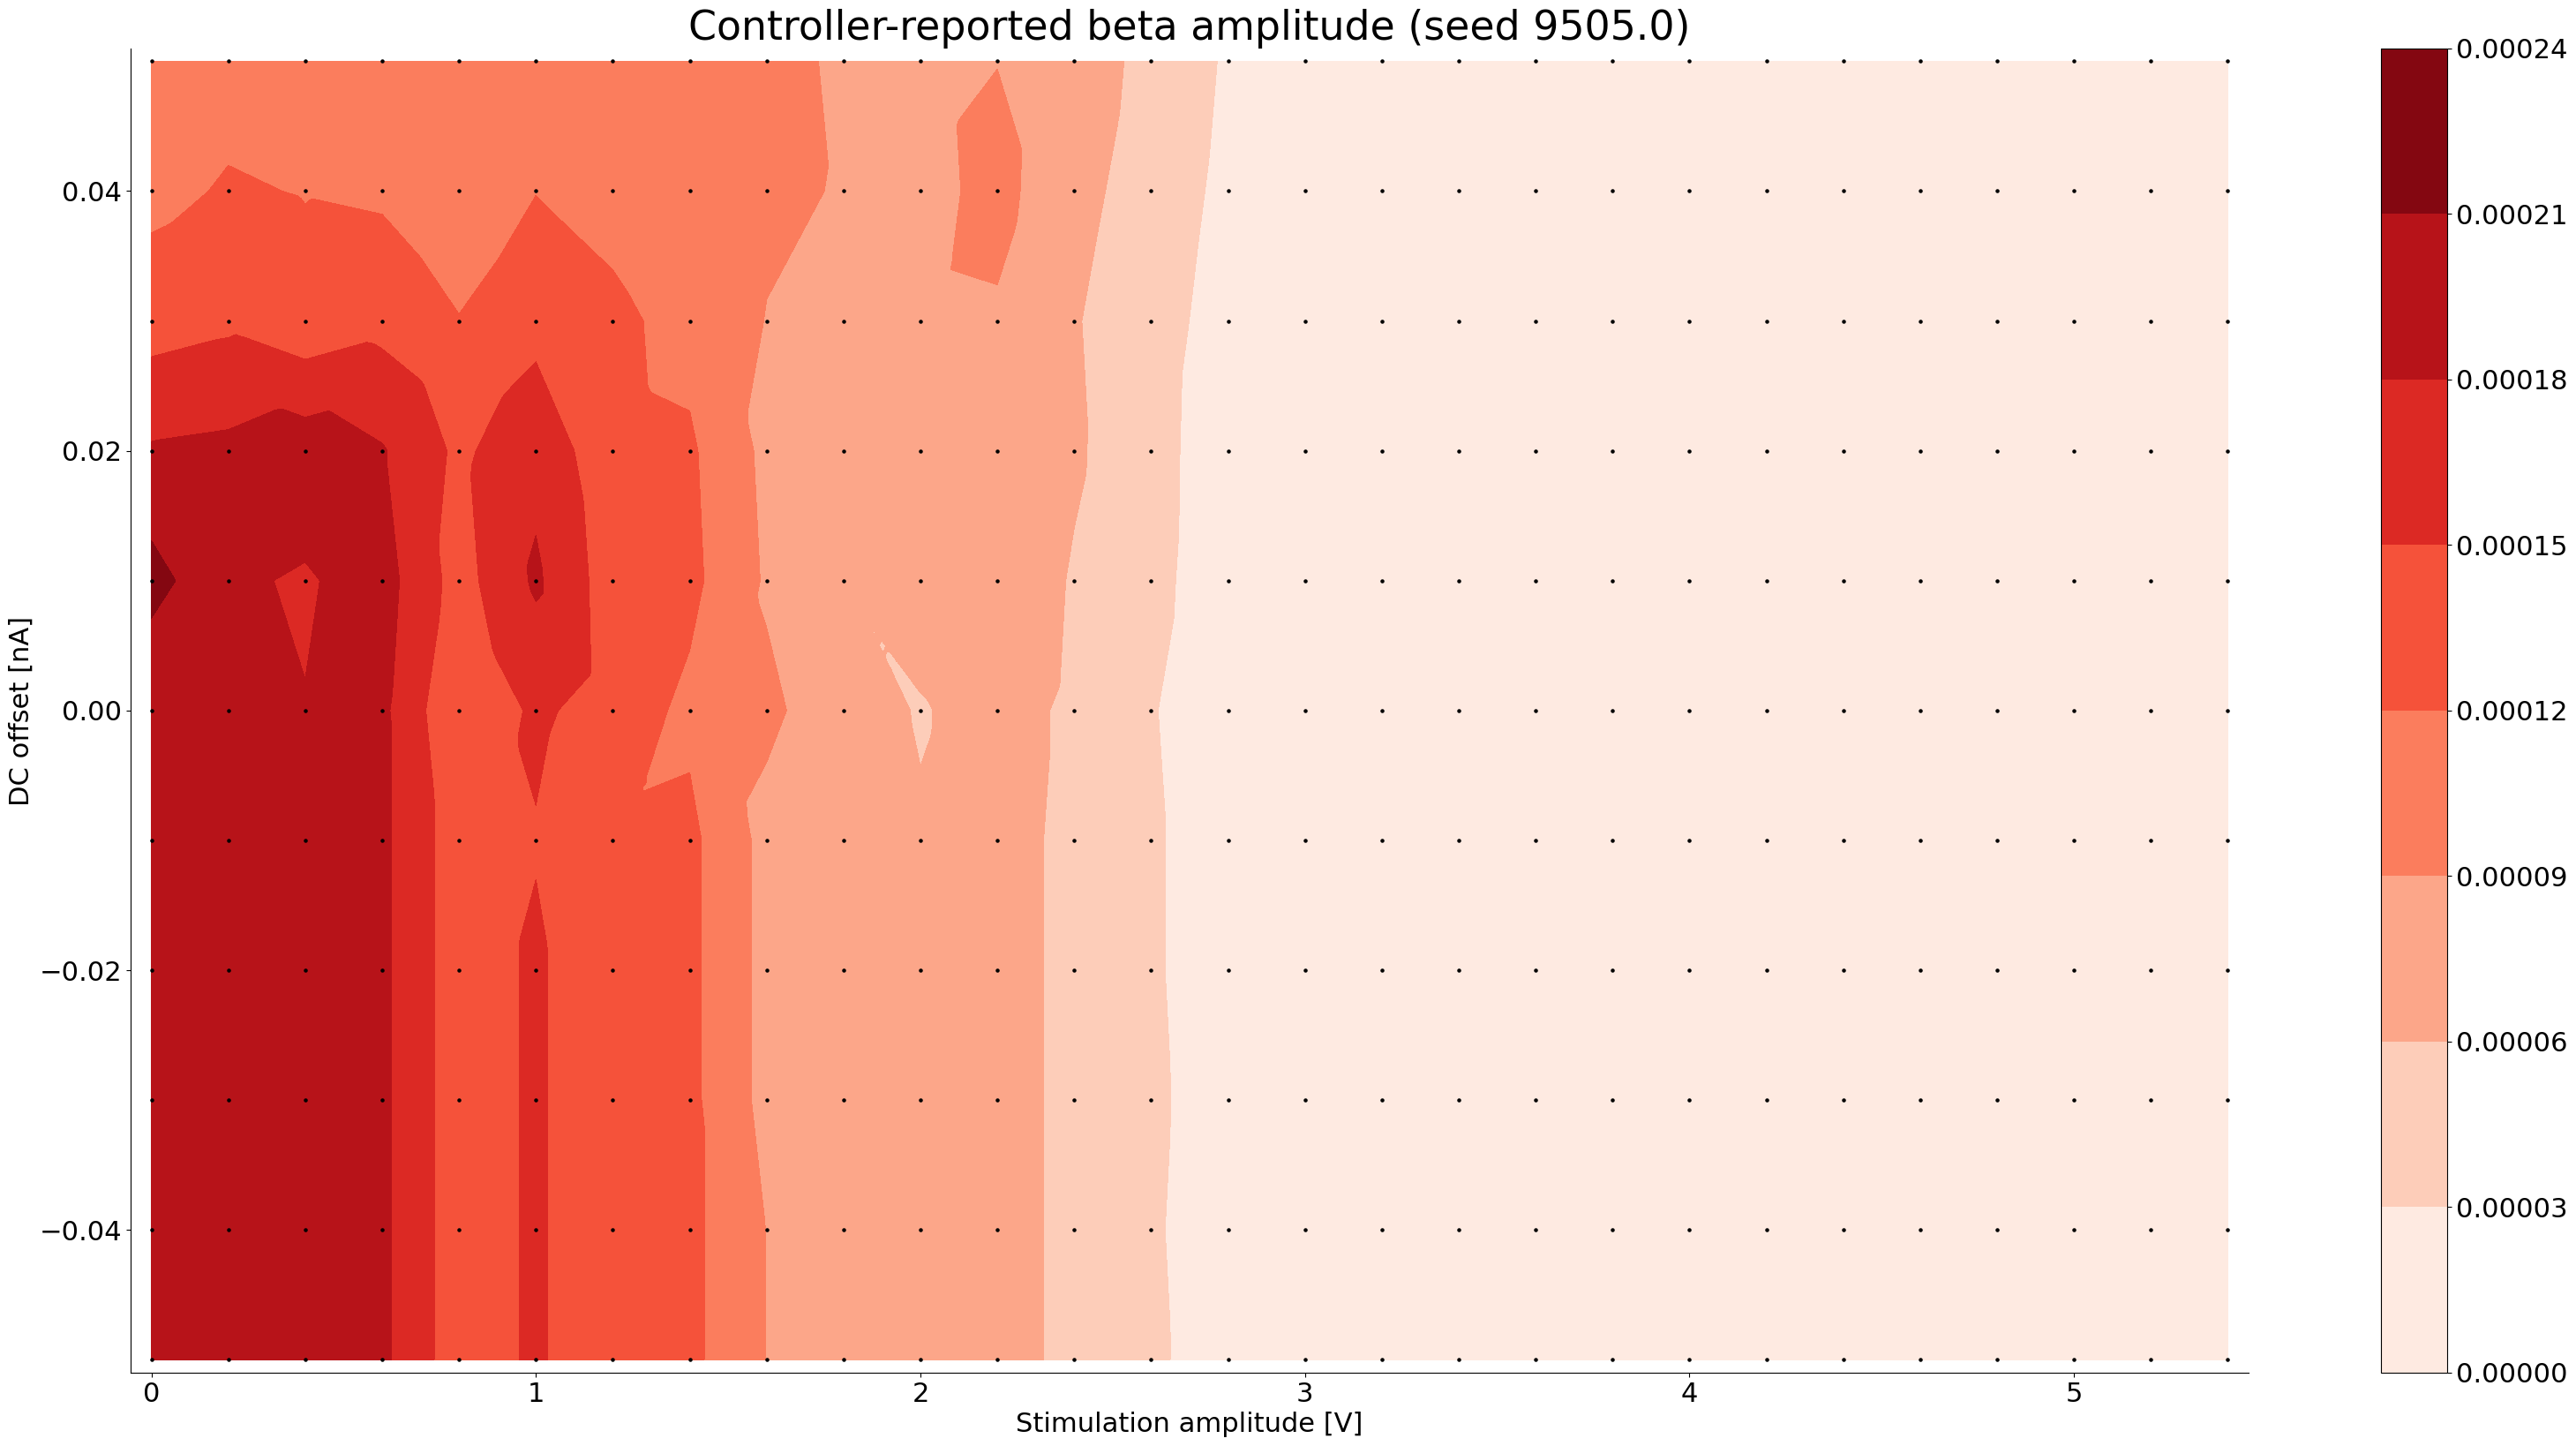

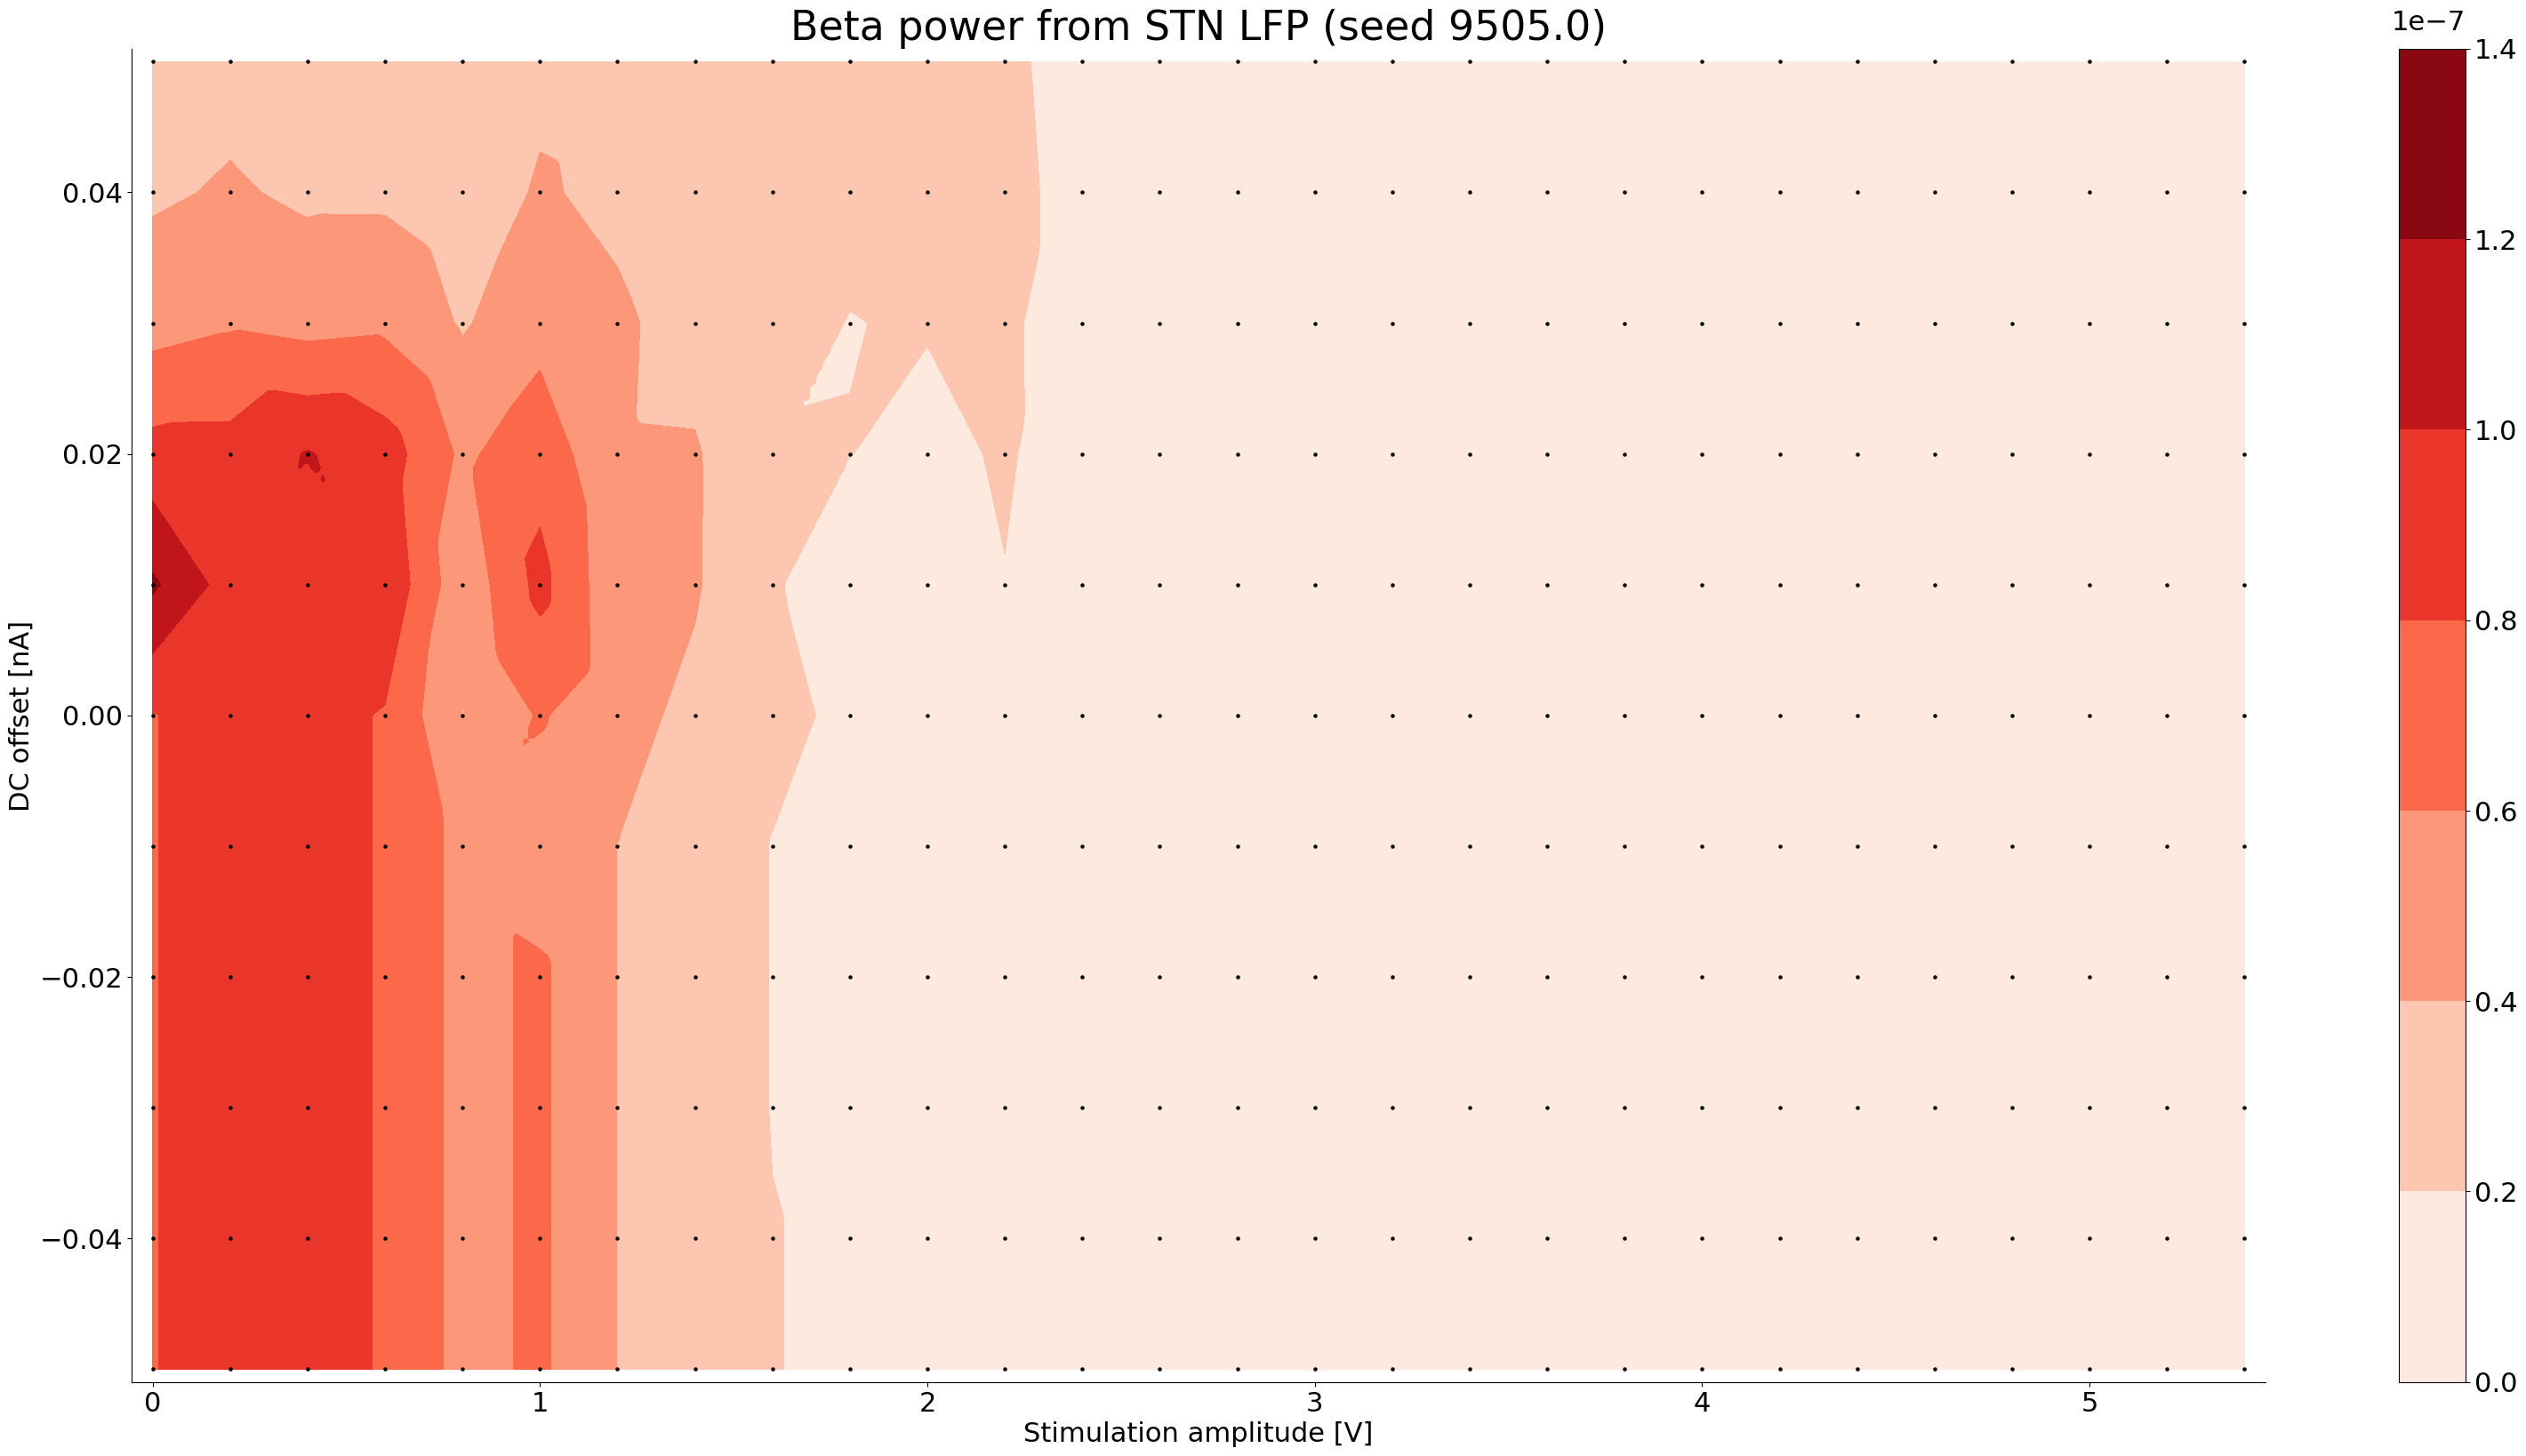

In [5]:
for seed in plot_data_per_seed:
    res = plot_data_per_seed[seed]
    xi = res["xi"]
    yi = res["yi"]
    zi = res["zi"]
    zi_lfp = res["zi_lfp"]
    x = res["x"]
    y = res["y"]
    
    fig = plt.figure(figsize=(30, 15))
    ax = fig.add_axes([0, 0, 1, 1])
    u.plot_colormap(fig, ax, x_orig=x, y_orig=y, x=xi, y=yi, z=zi, show_xy=True, cmap=cm.Reds)
    u.format_single_2d_plot(fig, "Stimulation amplitude [V]", "DC offset [nA]", f"Controller-reported beta amplitude (seed {seed})")
    
    fig = plt.figure(figsize=(30, 15))
    ax = fig.add_axes([0, 0, 1, 1])
    u.plot_colormap(fig, ax, x_orig=x, y_orig=y, x=xi, y=yi, z=zi_lfp, show_xy=True, cmap=cm.Reds)
    u.format_single_2d_plot(fig, "Stimulation amplitude [V]", "DC offset [nA]", f"Beta power from STN LFP (seed {seed})")

In [6]:
z_arrays = [plot_data_per_seed[e]["zi"] for e in plot_data_per_seed]
z_stacked = np.stack(z_arrays)
z_avg = np.mean(z_stacked, 0)
z_std = np.std(z_stacked, 0)

In [7]:
z_arrays_lfp = [plot_data_per_seed[e]["zi_lfp"] for e in plot_data_per_seed]
z_stacked_lfp = np.stack(z_arrays_lfp)
z_avg_lfp = np.mean(z_stacked_lfp, 0)
z_std_lfp = np.std(z_stacked_lfp, 0)

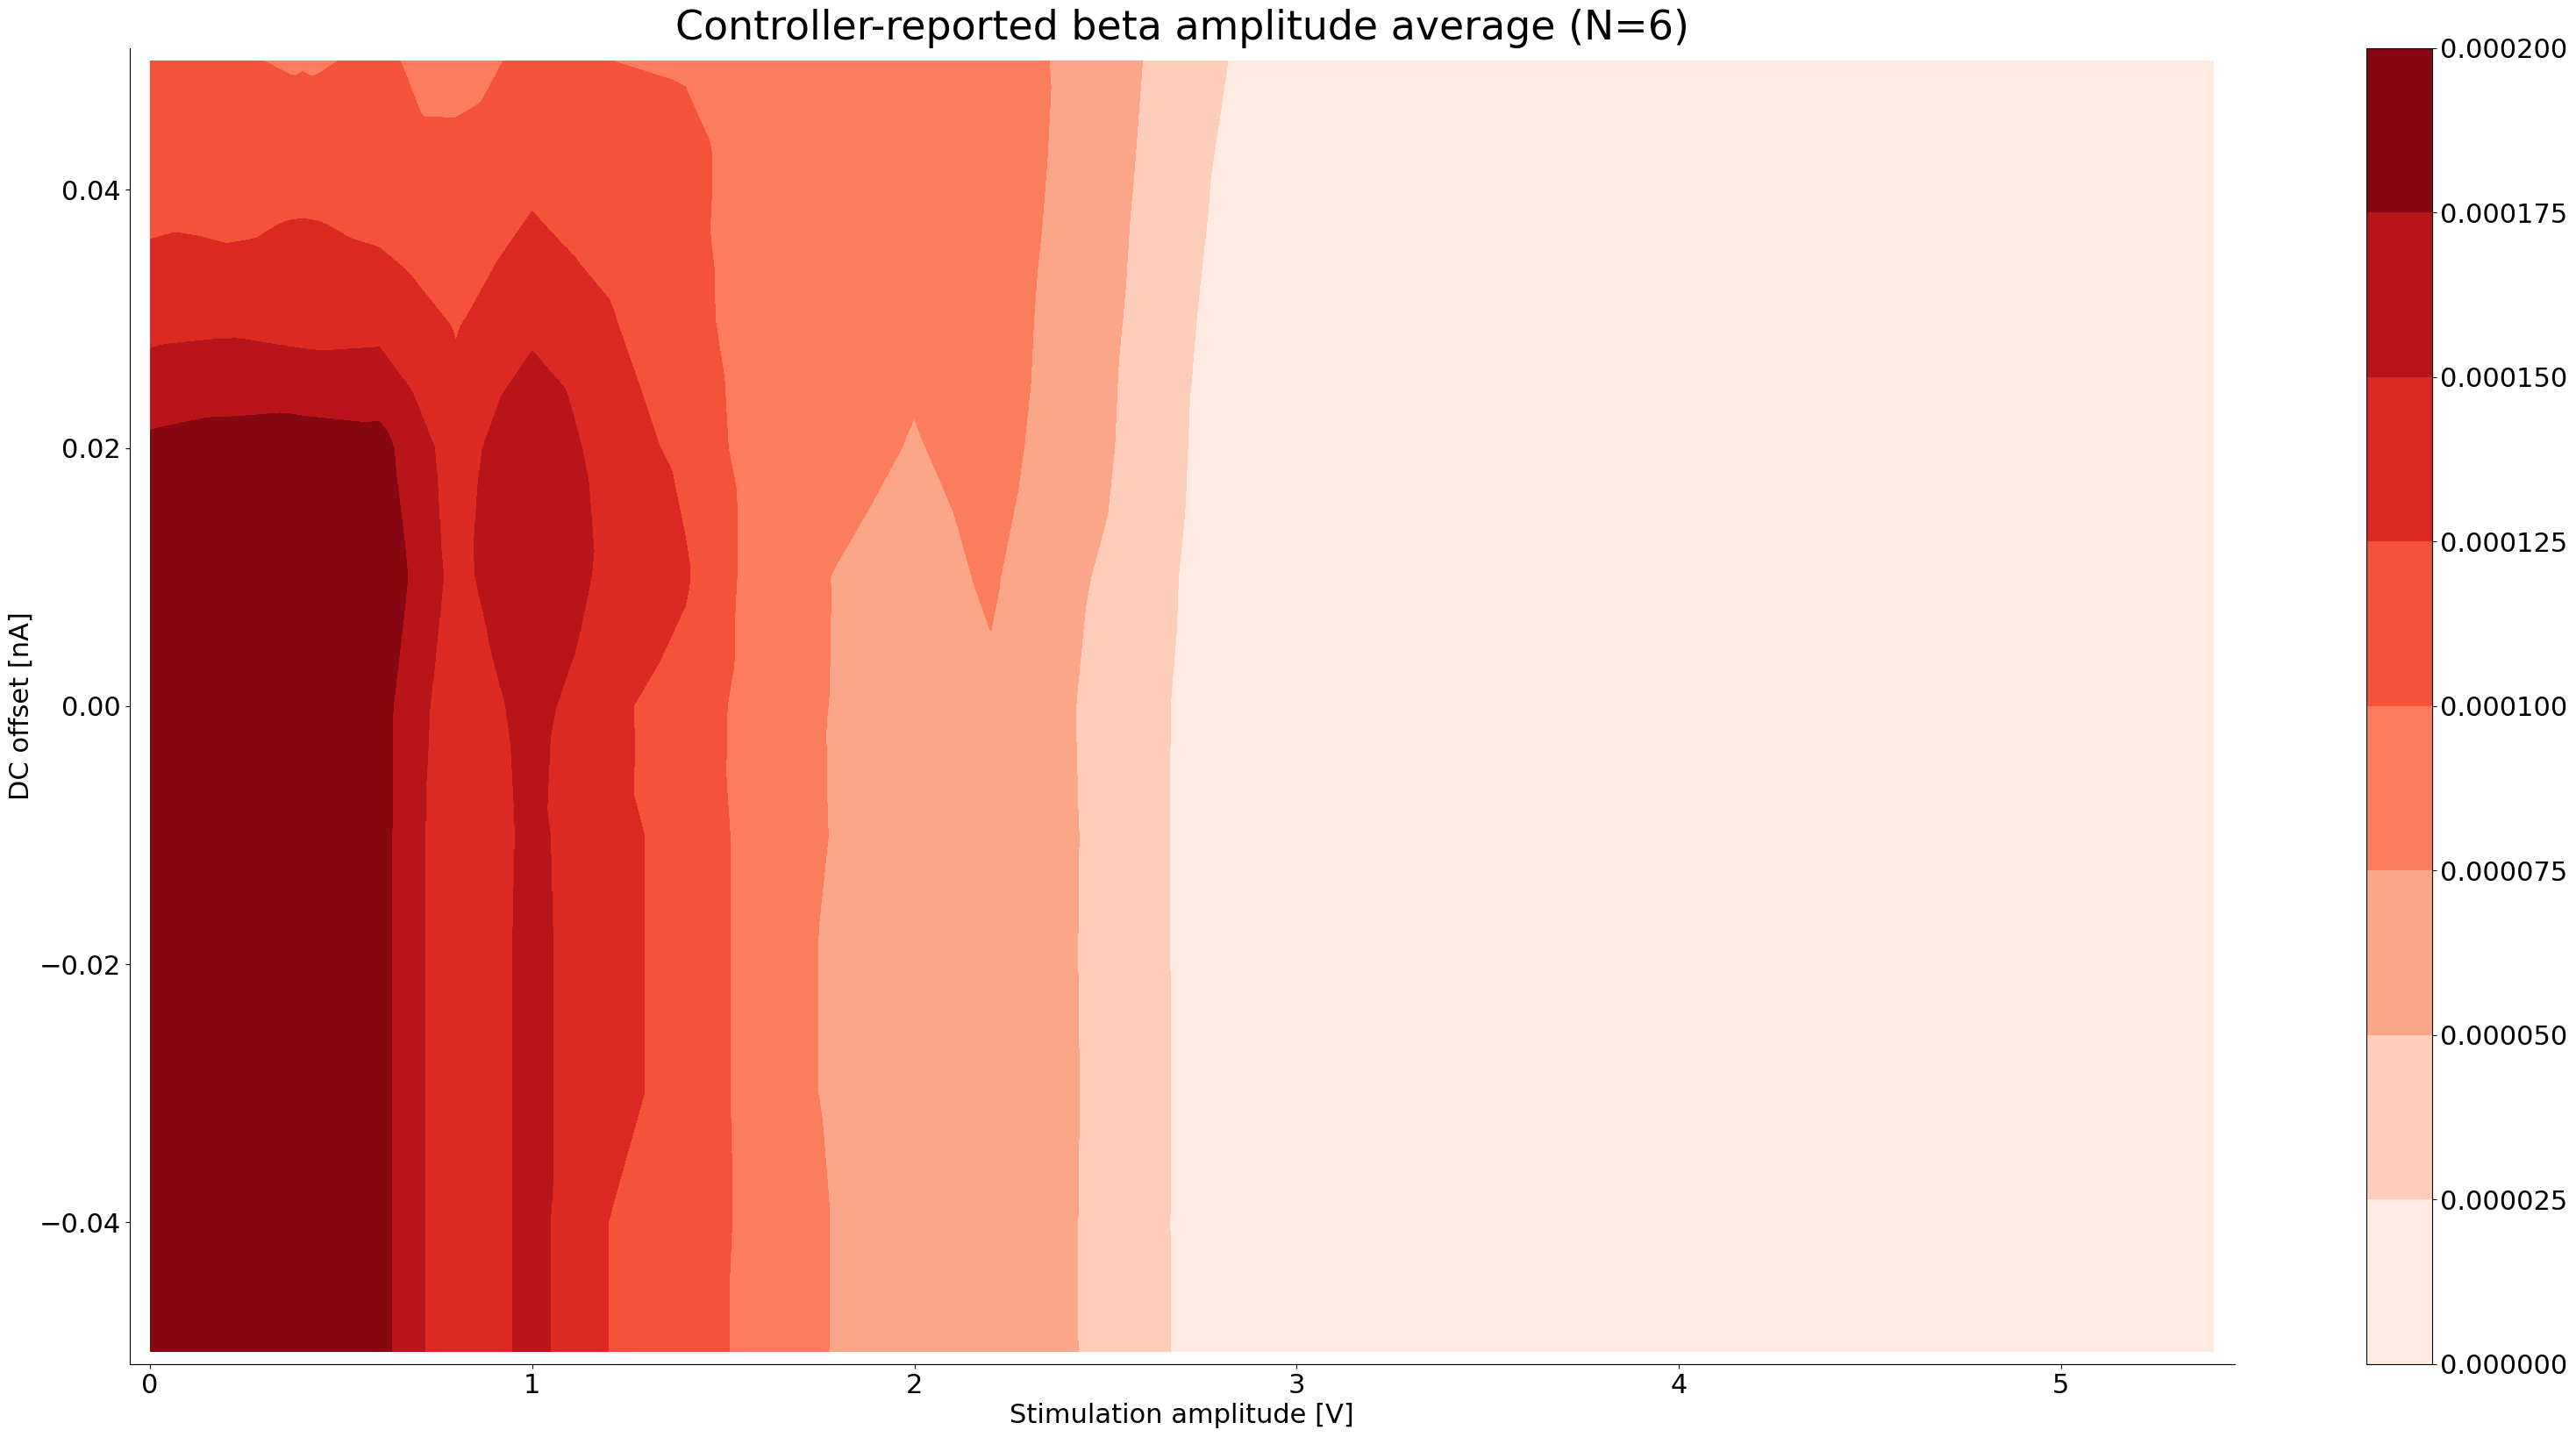

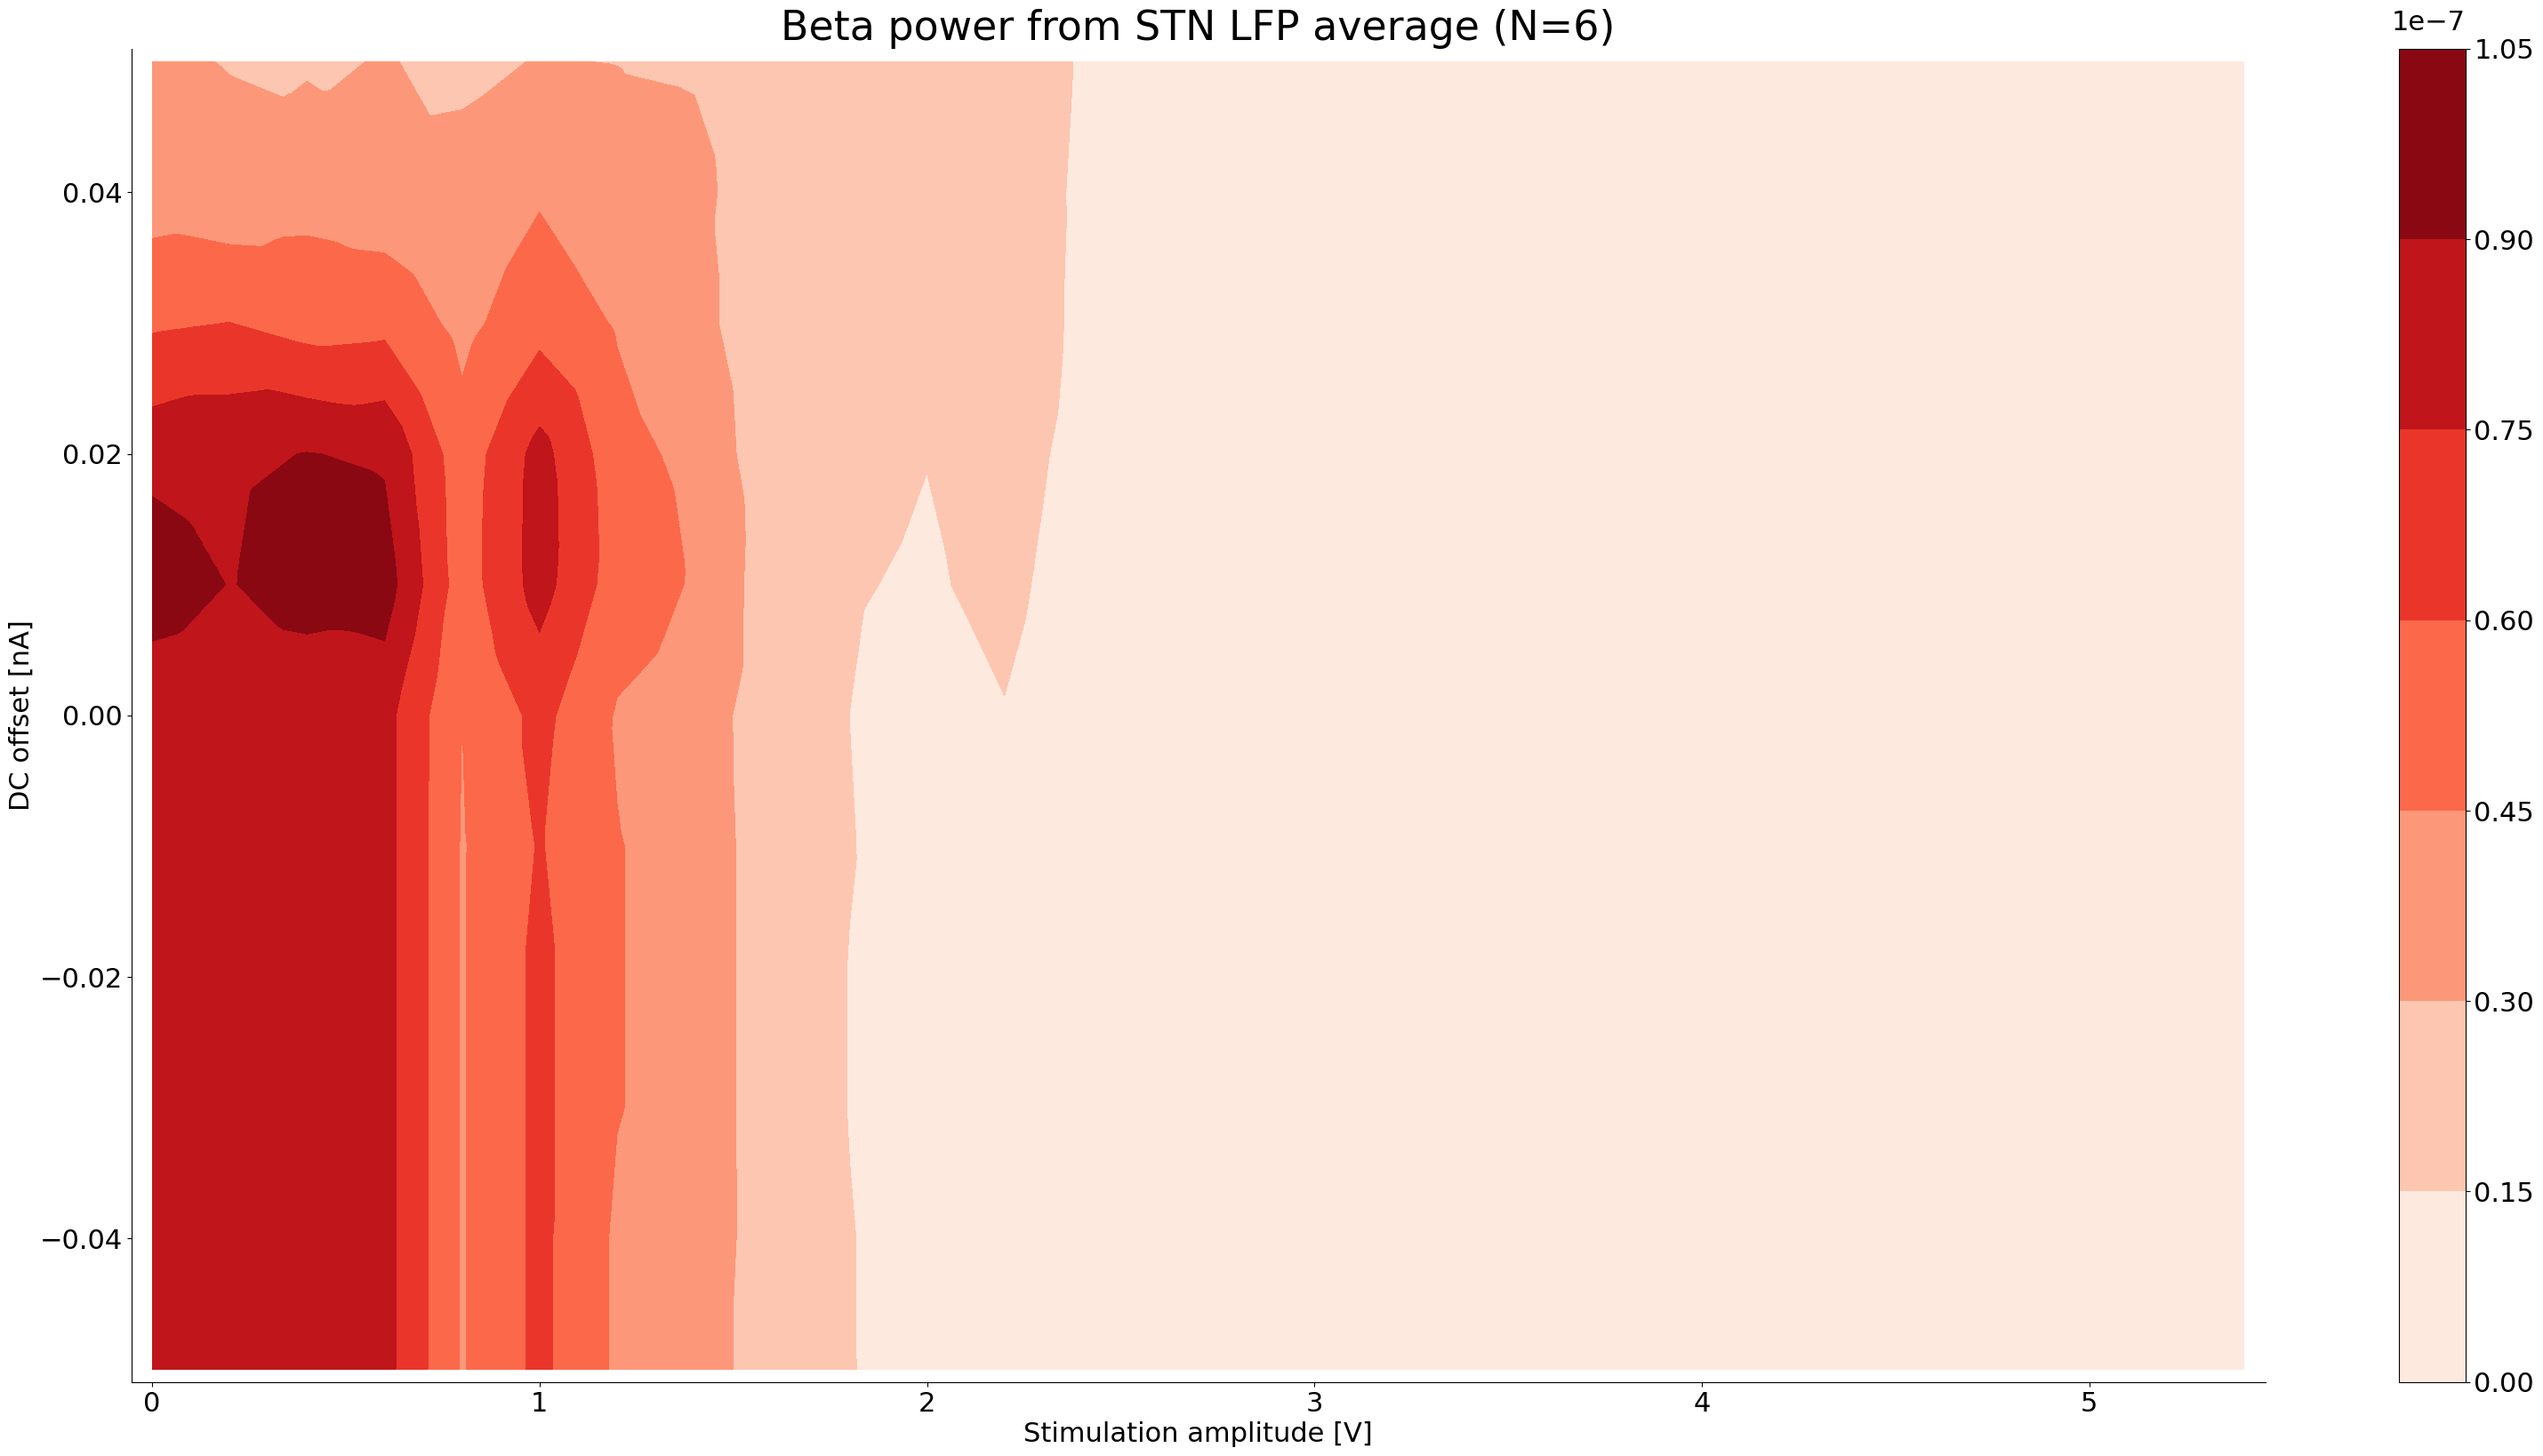

In [10]:
fig = plt.figure(figsize=(30, 15))
ax = fig.add_axes([0, 0, 1, 1])
u.plot_colormap(fig, ax, x_orig=x, y_orig=y, x=xi, y=yi, z=z_avg, cmap=cm.Reds)
u.format_single_2d_plot(fig, "Stimulation amplitude [V]", "DC offset [nA]", f"Controller-reported beta amplitude average (N={z_stacked.shape[0]})")

fig = plt.figure(figsize=(30, 15))
ax = fig.add_axes([0, 0, 1, 1])
u.plot_colormap(fig, ax, x_orig=x, y_orig=y, x=xi, y=yi, z=z_avg_lfp, cmap=cm.Reds)
u.format_single_2d_plot(fig, "Stimulation amplitude [V]", "DC offset [nA]", f"Beta power from STN LFP average (N={z_stacked.shape[0]})")

In [11]:
offset_list = yi[:, 0]
amplitude_list = xi[0, :]

@interact(dc_offset = widgets.FloatSlider(min=-0.05, max=0.05, step=0.005, value=0))
def plot_beta_slice(dc_offset=0):
    index = np.abs(offset_list - dc_offset).argmin()
    beta_avg = z_avg[index, :]
    beta_std = z_std[index, :]
    fig = plt.figure(figsize=(22, 5))
    plt.plot(amplitude_list, beta_avg, color="#8C031A")
    plt.fill_between(amplitude_list, beta_avg - beta_std, beta_avg + beta_std, color="#FC738A")
    plt.axhline(1.0414e-04, color="#000000", linestyle="--")
    ax = plt.gca()
    ax.set_ylim([0, 0.0002])
    u.format_single_axis(ax, "Stimulation amplitude [v]", "Beta power ARV", "")
    
    


interactive(children=(FloatSlider(value=0.0, description='dc_offset', max=0.05, min=-0.05, step=0.005), Output…

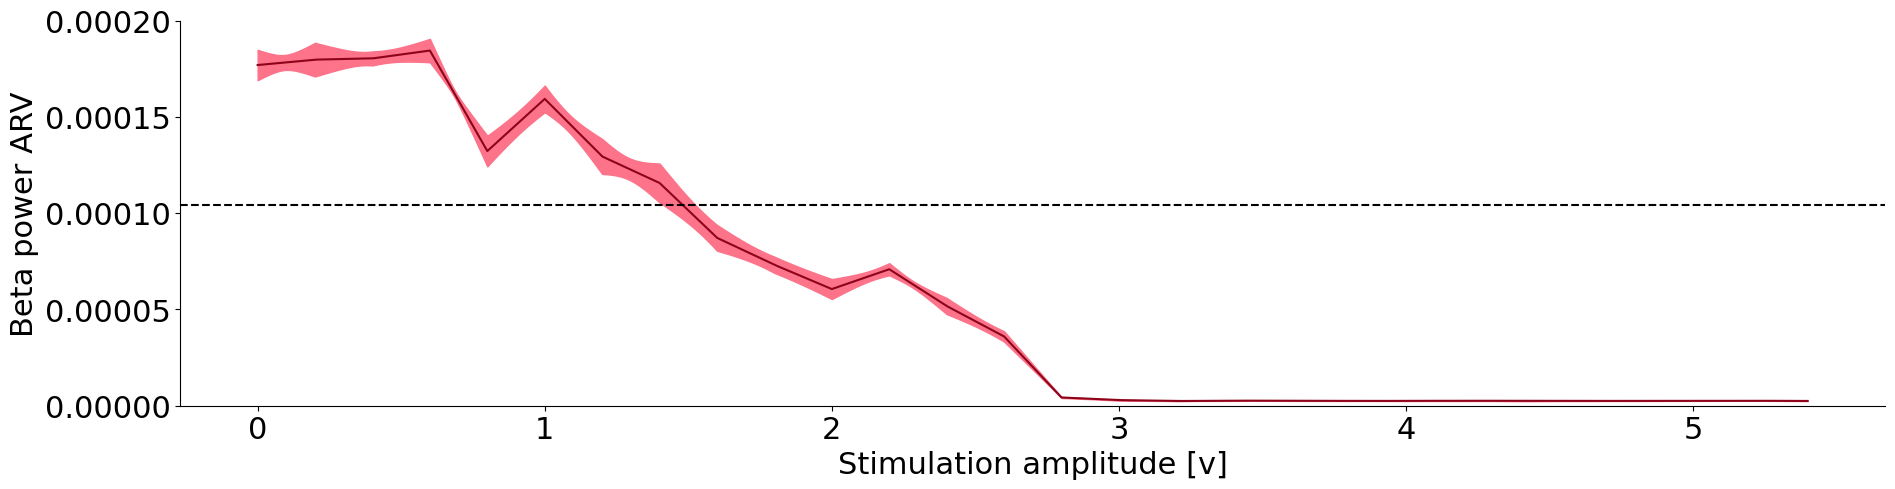

In [13]:
plot_beta_slice(dc_offset=0)
plt.savefig("beta_slice_0.svg", bbox_inches="tight")